In [1]:
%matplotlib inline

In [48]:
#import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
#from cv2 import VideoWriter, VideoWriter_fourcc
import pandas as pd
import torch
from scipy import signal, ndimage, spatial
from scipy.signal import correlate
from scipy.interpolate import CubicSpline
from scipy.ndimage import gaussian_filter
import math 

import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_curve, auc

from scipy.interpolate import interp1d
import scipy.stats as stats
from scipy.stats import spearmanr
import seaborn as sns


## Read the SLP Scores 

In [3]:
### LINUX BOX PATH
#path = r'/home/deniz/Code/ClinicalScoreProject/NeuroFace_Dataset/ALS/SLP_Assessment_ALS.csv'


# ALS DATA
path = r'/Users/denizjafari/documents/CODE/ClinicalScore/NeuroFace_Dataset/ALS/SLP_Assessment_ALS.csv'
df_als = pd.read_csv(path)

df_als = df_als.drop('Unnamed: 8', axis=1)

#print(df_als.shape)
#print(df_als.columns)
#print(df_als['Subject ID'].unique())
#df_als.head()

# STROKE DATA
path = r'/Users/denizjafari/documents/CODE/ClinicalScore/NeuroFace_Dataset/Stroke/SLP_Assessment_PS.csv'
df_ps = pd.read_csv(path)

df_ps = df_ps.drop('Unnamed: 8', axis=1)

#print(df_ps.shape)
#print(df_ps.columns)
#print(df_ps['Subject ID'].unique())
#df_ps.head()

# HEALTHY CONTROL DATA
path = r'/Users/denizjafari/documents/CODE/ClinicalScore/NeuroFace_Dataset/Healthy controls/SLP_Assessment_HC.csv'
df_hc = pd.read_csv(path)

df_hc = df_hc.drop('Unnamed: 8', axis=1)
df_hc = df_hc.drop('Unnamed: 15', axis=1)
#print(df_hc.shape)
#print(df_hc.columns)
#print(df_hc['Subject ID'].unique())



slp_scores = pd.concat([df_als, df_ps, df_hc], ignore_index=True)
# average of the clinical scores 

slp_scores['Tot_avg'] = slp_scores.apply(lambda row: (row['Tot (SLP1)'] + row["Tot (SLP2)"])/2, axis=1)
slp_scores['Symmetry_avg'] = slp_scores.apply(lambda row: (row['Symmetry (SLP1)'] + row["Symmetry (SLP2)"])/2, axis=1)
slp_scores['ROM_avg'] = slp_scores.apply(lambda row: (row['ROM (SLP1)'] + row["ROM (SLP2)"])/2, axis=1)
slp_scores['Speed_avg'] = slp_scores.apply(lambda row: (row['Speed (SLP1)'] + row["Speed (SLP2)"])/2, axis=1)
slp_scores['Variability_avg'] = slp_scores.apply(lambda row: (row['Variability (SLP1)'] + row["Variability (SLP2)"])/2, axis=1)
slp_scores['Fatigue_avg'] = slp_scores.apply(lambda row: (row['Fatigue (SLP1)'] + row["Fatigue (SLP2)"])/2, axis=1)


tasks = ['BBP_NORMAL',  'PATAKA', 'PA','BLOW', 'KISS','NSM_OPEN', 'NSM_SPREAD', 'NSM_BIGSMILE' ,'BROW']

ids = ['A', 'O', 'S', 'N']

def task_labeler(row):
    for t in tasks: 
        if t in row: 
            return t
        
def pop_labeler(row):
    for i in ids:
        if i in row:
            if i == "A":
                return 'ALS'
            elif i == 'O' or i == "S":
                return 'Stroke'
            else:
                return 'HC'
    

slp_scores['task'] = [task_labeler(x) for x in slp_scores['File Name']]
slp_scores['population'] = [pop_labeler(x) for x in slp_scores['Subject ID']]

print(slp_scores.shape)
print(slp_scores.columns)
print()
print('Total numbr of participants are: ',len(slp_scores['Subject ID'].unique()))
print()
print('Subject IDs included are: ',slp_scores['Subject ID'].unique())
print()
print(slp_scores.columns)
print()
print('The tasks are: ', slp_scores['task'].unique())

slp_scores.head()



(261, 22)
Index(['File Name', 'Subject ID', 'Symmetry (SLP1)', 'ROM (SLP1)',
       'Speed (SLP1)', 'Variability (SLP1)', 'Fatigue (SLP1)', 'Tot (SLP1)',
       'Symmetry (SLP2)', 'ROM (SLP2)', 'Speed (SLP2)', 'Variability (SLP2)',
       'Fatigue (SLP2)', 'Tot (SLP2)', 'Tot_avg', 'Symmetry_avg', 'ROM_avg',
       'Speed_avg', 'Variability_avg', 'Fatigue_avg', 'task', 'population'],
      dtype='object')

Total numbr of participants are:  36

Subject IDs included are:  ['A002' 'A006' 'A008' 'A009' 'A010' 'A011' 'A012' 'A014' 'A015' 'A016'
 'A017' 'OP01' 'OP02' 'OP03' 'S001' 'S002' 'S003' 'S005' 'S006' 'S007'
 'S008' 'S009' 'S011' 'S012' 'S013' 'N001' 'N002' 'N003' 'N004' 'N007'
 'N008' 'N010' 'N011' 'N012' 'N017' 'N019']

Index(['File Name', 'Subject ID', 'Symmetry (SLP1)', 'ROM (SLP1)',
       'Speed (SLP1)', 'Variability (SLP1)', 'Fatigue (SLP1)', 'Tot (SLP1)',
       'Symmetry (SLP2)', 'ROM (SLP2)', 'Speed (SLP2)', 'Variability (SLP2)',
       'Fatigue (SLP2)', 'Tot (SLP2)', 'Tot_av

,File Name,Subject ID,Symmetry (SLP1),ROM (SLP1),Speed (SLP1),Variability (SLP1),Fatigue (SLP1),Tot (SLP1),Symmetry (SLP2),ROM (SLP2),...,Fatigue (SLP2),Tot (SLP2),Tot_avg,Symmetry_avg,ROM_avg,Speed_avg,Variability_avg,Fatigue_avg,task,population
0,A002_02_BBP_NORMAL_color.avi,A002,1,1,1,1,1,5,2,1,...,1,6,5.5,1.5,1.0,1.0,1.0,1.0,BBP_NORMAL,ALS
1,A002_02_DDK_PATAKA_color.avi,A002,1,1,1,1,1,5,2,2,...,2,9,7.0,1.5,1.5,1.0,1.5,1.5,PATAKA,ALS
2,A002_02_DDK_PA_color.avi,A002,1,1,1,1,1,5,2,2,...,2,9,7.0,1.5,1.5,1.0,1.5,1.5,PA,ALS
3,A002_02_NSM_BLOW_color.avi,A002,2,1,1,2,1,7,1,2,...,1,8,7.5,1.5,1.5,1.5,2.0,1.0,BLOW,ALS
4,A002_02_NSM_KISS_color.avi,A002,2,1,1,1,4,9,1,1,...,3,7,8.0,1.5,1.0,1.0,1.0,3.5,KISS,ALS


In [4]:

print(df_als['Subject ID'].unique())
print(len(df_als['Subject ID'].unique()))

print(df_ps['Subject ID'].unique())
print(len(df_ps['Subject ID'].unique()))

print(df_hc['Subject ID'].unique())
print(len(df_hc['Subject ID'].unique()))



['A002' 'A006' 'A008' 'A009' 'A010' 'A011' 'A012' 'A014' 'A015' 'A016'
 'A017']
11
['OP01' 'OP02' 'OP03' 'S001' 'S002' 'S003' 'S005' 'S006' 'S007' 'S008'
 'S009' 'S011' 'S012' 'S013']
14
['N001' 'N002' 'N003' 'N004' 'N007' 'N008' 'N010' 'N011' 'N012' 'N017'
 'N019']
11


In [5]:
a = slp_scores.groupby(['population', 'task']).count()

slp_scores.groupby(['population','task'])['Tot_avg', 'Symmetry_avg', 'ROM_avg',
       'Speed_avg', 'Variability_avg', 'Fatigue_avg'].describe()


<ipython-input-5-cbf6efbffae7>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  slp_scores.groupby(['population','task'])['Tot_avg', 'Symmetry_avg', 'ROM_avg',


Tot_avg                                          \
                          count       mean       std  min    25%    50%   
population task                                                           
ALS        BBP_NORMAL       9.0   7.611111  1.850300  5.5  6.000   7.00   
           BLOW             6.0   6.416667  0.801041  5.5  5.750   6.50   
           BROW             4.0   5.500000  0.408248  5.0  5.375   5.50   
           KISS            11.0   7.590909  2.467977  5.5  6.000   6.50   
           NSM_BIGSMILE     4.0   9.125000  1.750000  7.0  8.125   9.25   
           NSM_OPEN        11.0   6.363636  1.097518  5.0  5.500   6.50   
           NSM_SPREAD      11.0   9.590909  3.104981  6.0  7.500   8.50   
           PA              10.0   8.200000  1.960725  6.5  6.625   7.50   
           PATAKA          10.0   8.450000  1.423025  5.5  8.000   8.75   
HC         BBP_NORMAL      11.0   5.863636  0.595437  5.0  5.500   5.50   
           BLOW             7.0   5.785714  0.906327  5.0  5.000   6.00   
           BROW             4.0   5.625000  1.250000  5.0  5.000   5.00   
           KISS            11.0   5.772727  0.646670  5.0  5.500   5.50   
           NSM_BIGSMILE     3.0   6.500000  1.500000  5.0  5.750   6.50   
           NSM_OPEN        11.0   5.545455  0.522233  5.0  5.000   5.50   
           NSM_SPREAD      11.0   6.772727  2.078024  5.0  5.000   6.00   
           PA              11.0   5.590909  0.583874  5.0  5.000   5.50   
           PATAKA          11.0   5.863636  0.896965  5.0  5.000   5.50   
Stroke     BBP_NORMAL      14.0   9.107143  2.489814  5.0  7.500   9.00   
           BLOW            11.0   7.363636  2.025968  5.5  6.250   7.00   
           BROW             7.0   8.642857  3.543942  5.0  6.250   7.00   
           KISS            14.0   8.785714  2.599662  5.0  7.000   8.75   
           NSM_BIGSMILE     3.0   6.333333  1.154701  5.0  6.000   7.00   
           NSM_OPEN        14.0   6.892857  1.163195  5.0  6.500   6.50   
           NSM_SPREAD      14.0  10.750000  2.585090  6.0  9.500  10.00   
           PA              14.0   9.607143  2.482079  6.0  7.750   9.50   
           PATAKA          14.0   8.785714  2.100497  5.5  7.000   9.25   

                                      Symmetry_avg            ...  \
                            75%   max        count      mean  ...   
population task                                               ...   
ALS        BBP_NORMAL     9.000  11.0          9.0  1.833333  ...   
           BLOW           6.875   7.5          6.0  1.750000  ...   
           BROW           5.625   6.0          4.0  1.125000  ...   
           KISS           8.500  14.0         11.0  1.681818  ...   
           NSM_BIGSMILE  10.250  11.0          4.0  2.125000  ...   
           NSM_OPEN       7.000   8.5         11.0  1.590909  ...   
           NSM_SPREAD    11.500  15.0         11.0  1.772727  ...   
           PA             9.000  12.5         10.0  1.900000  ...   
           PATAKA         9.375  10.5         10.0  1.850000  ...   
HC         BBP_NORMAL     6.250   7.0         11.0  1.318182  ...   
           BLOW           6.000   7.5          7.0  1.357143  ...   
           BROW           5.625   7.5          4.0  1.125000  ...   
           KISS           6.250   7.0         11.0  1.272727  ...   
           NSM_BIGSMILE   7.250   8.0          3.0  1.500000  ...   
           NSM_OPEN       6.000   6.5         11.0  1.454545  ...   
           NSM_SPREAD     8.500  11.0         11.0  1.409091  ...   
           PA             6.000   6.5         11.0  1.227273  ...   
           PATAKA         6.500   7.5         11.0  1.363636  ...   
Stroke     BBP_NORMAL    10.500  13.5         14.0  2.571429  ...   
           BLOW           7.250  11.5         11.0  2.045455  ...   
           BROW          10.500  15.0          7.0  1.857143  ...   
           KISS           9.875  14.0         14.0  2.178571  ...   
           NSM_BIGSMILE   7.000   7.0          3

In [6]:
slp_scores.groupby(['population']).count()

,File Name,Subject ID,Symmetry (SLP1),ROM (SLP1),Speed (SLP1),Variability (SLP1),Fatigue (SLP1),Tot (SLP1),Symmetry (SLP2),ROM (SLP2),...,Variability (SLP2),Fatigue (SLP2),Tot (SLP2),Tot_avg,Symmetry_avg,ROM_avg,Speed_avg,Variability_avg,Fatigue_avg,task
population,,,,,,,,,,,,,,,,,,,,,
ALS,76,76,76,76,76,76,76,76,76,76,...,76,76,76,76,76,76,76,76,76,76
HC,80,80,80,80,80,80,80,80,80,80,...,80,80,80,80,80,80,80,80,80,80
Stroke,105,105,105,105,105,105,105,105,105,105,...,105,105,105,105,105,105,105,105,105,105


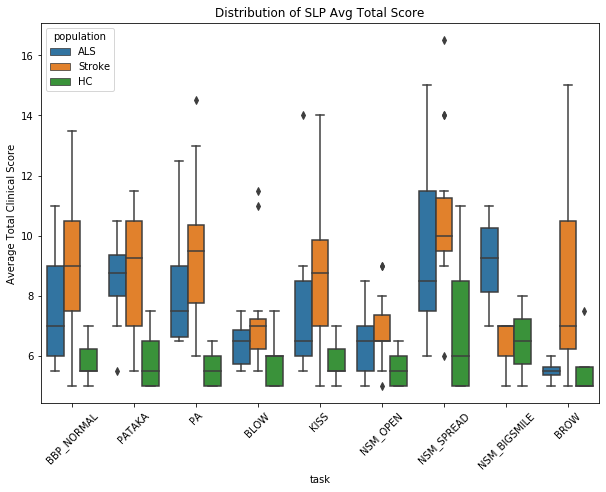

In [7]:
# Clinical Scores
ax, figure = plt.subplots(figsize=(10,7))
g = sns.boxplot(x='task', y='Tot_avg',data=slp_scores, hue='population')
plt.title('Distribution of SLP Total Score')
g.set_xticklabels(g.get_xticklabels(), rotation=45)

plt.ylabel('Average Total Clinical Score')
plt.title('Distribution of SLP Avg Total Score')

plt.show()

if 0:
    sns.boxplot(x=df['Subject ID'], y=df['Tot (SLP2)'])
    plt.title('Distribution of SLP2 Total Score')
    plt.show()

    sns.boxplot(x=df['Subject ID'], y=df['Tot_avg'])
    plt.title('Distribution of SLP Avg Total Score')
    plt.show()

In [8]:
neuroface_subjects = slp_scores['Subject ID'].unique()
neuroface_subjects

array(['A002', 'A006', 'A008', 'A009', 'A010', 'A011', 'A012', 'A014',
       'A015', 'A016', 'A017', 'OP01', 'OP02', 'OP03', 'S001', 'S002',
       'S003', 'S005', 'S006', 'S007', 'S008', 'S009', 'S011', 'S012',
       'S013', 'N001', 'N002', 'N003', 'N004', 'N007', 'N008', 'N010',
       'N011', 'N012', 'N017', 'N019'], dtype=object)

In [9]:
def hc_label_change(sub_id):
    s = sub_id
    if 'N' in sub_id: 
        
        s = s.replace('N0', 'NF')

    return s



In [10]:
slp_scores['Subject ID'] = [hc_label_change(x) for x in slp_scores['Subject ID']]

In [11]:
slp_scores['Subject ID'].unique()

array(['A002', 'A006', 'A008', 'A009', 'A010', 'A011', 'A012', 'A014',
       'A015', 'A016', 'A017', 'OP01', 'OP02', 'OP03', 'S001', 'S002',
       'S003', 'S005', 'S006', 'S007', 'S008', 'S009', 'S011', 'S012',
       'S013', 'NF01', 'NF02', 'NF03', 'NF04', 'NF07', 'NF08', 'NF10',
       'NF11', 'NF12', 'NF17', 'NF19'], dtype=object)

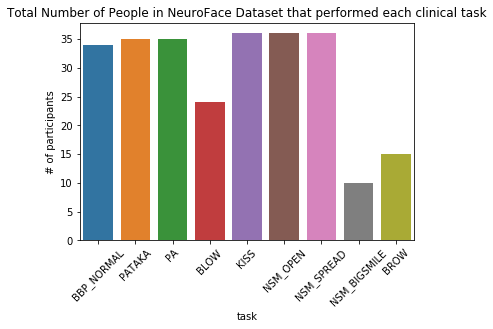

In [12]:
# TASKS 

g = sns.countplot(x='task',data=slp_scores)
g.set_xticklabels(g.get_xticklabels(), rotation=45)

# set axes labels and title
plt.ylabel('# of participants')
plt.title('Total Number of People in NeuroFace Dataset that performed each clinical task')
plt.show()

//anaconda3/envs/csc2541/lib/python3.8/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


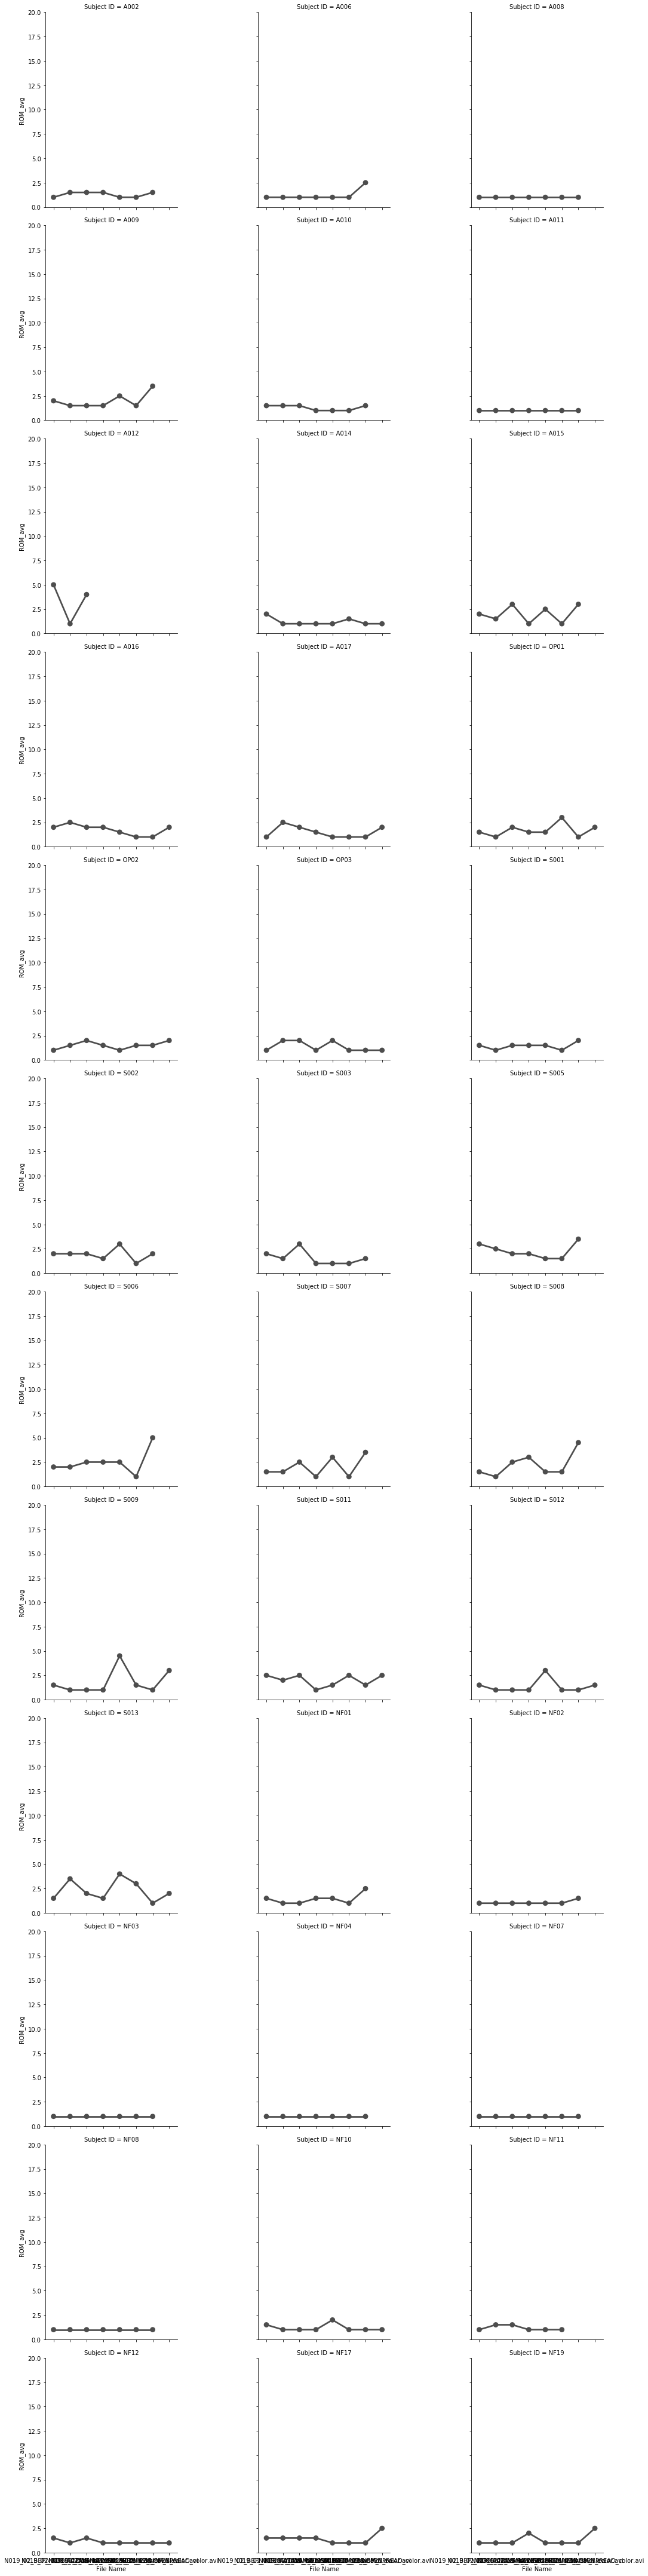

In [13]:
g = sns.FacetGrid(slp_scores, col="Subject ID", col_wrap=3, height=5, ylim=(0, 20))
g.map(sns.pointplot, "File Name", "ROM_avg",color=".3", ci=None);


//anaconda3/envs/csc2541/lib/python3.8/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


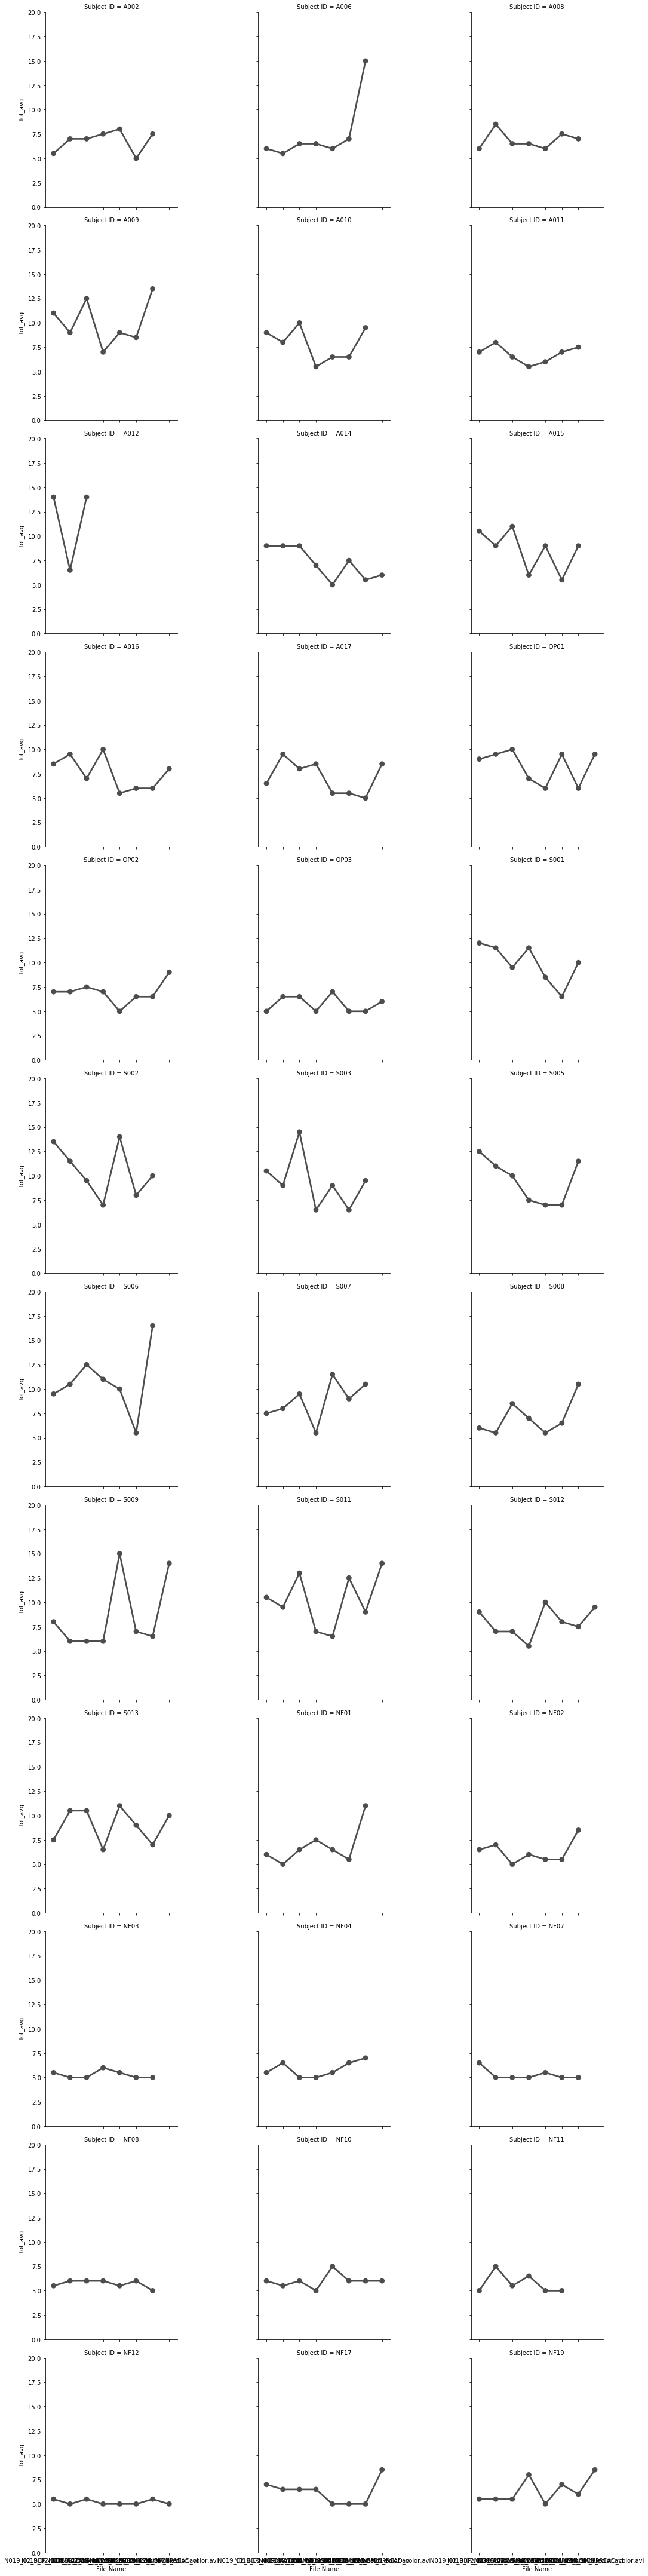

In [14]:
g = sns.FacetGrid(slp_scores, col="Subject ID", col_wrap=3, height=5, ylim=(0, 20))
g.map(sns.pointplot, "File Name", "Tot_avg",color=".3", ci=None);


In [15]:

path2 = r'/Users/denizjafari/documents/CODE/ClinicalScore/NeuroFace_Dataset/ALS/VID_DATASET_Clinical information_ALS.csv'
als_df_demog = pd.read_csv(path2)

print(len(als_df_demog))
print(als_df_demog.columns)
print(als_df_demog.SubjectID.unique())
als_df_demog.head()

10
Index(['SubjectID', 'AgeSession', 'Gender', 'DisDurDiag', 'AgeDiag',
       'DisDurON', 'AgeOnset', 'SiteOnset', 'ALSFRSTot', 'ALSFRSBulb',
       'Intell (%)', 'SpeakRate (words/min)'],
      dtype='object')
['A002' 'A006' 'A008' 'A009' 'A010' 'A011' 'A012' 'A014' 'A015' 'A017']


,SubjectID,AgeSession,Gender,DisDurDiag,AgeDiag,DisDurON,AgeOnset,SiteOnset,ALSFRSTot,ALSFRSBulb,Intell (%),SpeakRate (words/min)
0,A002,62,F,19,60,31,59,Lower limbs,31,12,100,151.72
1,A006,64,F,20,62,109,55,Upper/Lower limbs,26,12,96.36,122.68
2,A008,55,M,15,54,28,53,Upper limbs,39,11,91.82,143.17
3,A009,45,F,29,42,41,41,Lower limbs,26,7,28.18,63.28
4,A010,68,M,10,67,26,66,Upper limbs,40,12,87.27,88.61


In [64]:
for i, s in enumerate(neuroface_subjects):
    if 'N' in s:
        s = s.replace('N0', 'NF')
        neuroface_subjects[i] = s
        
        
print(neuroface_subjects)
print(len(neuroface_subjects))

['A002' 'A006' 'A008' 'A009' 'A010' 'A011' 'A012' 'A014' 'A015' 'A016'
 'A017' 'OP01' 'OP02' 'OP03' 'S001' 'S002' 'S003' 'S005' 'S006' 'S007'
 'S008' 'S009' 'S011' 'S012' 'S013' 'NF01' 'NF02' 'NF03' 'NF04' 'NF07'
 'NF08' 'NF10' 'NF11' 'NF12' 'NF17' 'NF19']
36


# Fine-Tuned Diego's Results 

In [16]:
def print_prop(df, file):
    print(file)
    print('Shape: ',df.shape)
    print()
    print(df.columns)
    print()
    print('Total Number of Subjects in Df are: ', len(df.subject_id.unique()))
    print("Subjects IDs are: ",df.subject_id.unique())
    print()



### Diego Stroke DATA 

In [17]:
### STROKE DATA

tasks = ['BBP_NORMAL', 'NSM_OPEN', 'NSM_SPREAD', 'NSM_BIGSMILE']
task = 0# 0-> NORMAL_BBP, 1-> NSM_OPEN, 2-> NSM_SPREAD, 3->NSM_BIGSMILE

stroke_file_1 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/Stroke_vs_Controls_all_finetuned/metric_output_"+tasks[task]+".csv"
stroke_file_2 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/Stroke_vs_Controls_database_finetuned/metric_output_"+tasks[task]+".csv"
stroke_file_3 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/Stroke_vs_Controls_new_finetuned/metric_output_"+tasks[task]+".csv"
stroke_file_4 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/Stroke_vs_Controls_old_finetuned/metric_output_"+tasks[task]+".csv"


bbp_s_df_1 = pd.read_csv(stroke_file_1)
bbp_s_df_1 = bbp_s_df_1.drop('Unnamed: 0', axis=1)
print_prop(bbp_s_df_1, stroke_file_1)



bbp_s_df_2 = pd.read_csv(stroke_file_2)
bbp_s_df_2 = bbp_s_df_2.drop('Unnamed: 0', axis=1)
print_prop(bbp_s_df_2, stroke_file_2)



bbp_s_df_3 = pd.read_csv(stroke_file_3)
bbp_s_df_3 = bbp_s_df_3.drop('Unnamed: 0', axis=1)
print_prop(bbp_s_df_3, stroke_file_3)



bbp_s_df_4 = pd.read_csv(stroke_file_4)
bbp_s_df_4 = bbp_s_df_4.drop('Unnamed: 0', axis=1)
print_prop(bbp_s_df_4, stroke_file_4)

/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/Stroke_vs_Controls_all_finetuned/metric_output_BBP_NORMAL.csv
Shape:  (457, 18)

Index(['subject_id', 'task', 'type', 'rep', 'O_MAX', 'O_MIN', 'O_MAX_VEL',
       'O_MIN_VEL', 'W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL', 'A_MOUTH',
       'R_LCRC', 'D_0', 'D_1', 'D_2', 'D_3'],
      dtype='object')

Total Number of Subjects in Df are:  45
Subjects IDs are:  ['NF11' 'NF12' 'NF13' 'NF14' 'NF15' 'NF16' 'NF17' 'NF18' 'NF19' 'NF20'
 'NF21' 'NF22' 'NF24' 'NF26' 'NF27' 'NF00' 'NF02' 'NF03' 'NF04' 'NF05'
 'NF06' 'NF07' 'NF08' 'NF09' 'NF10' 'OP01' 'OP02' 'OP03' 'OP05' 'OP06'
 'OP07' 'OP08' 'OP09' 'OP10' 'OP12' 'S001' 'S002' 'S003' 'S005' 'S006'
 'S007' 'S008' 'S009' 'S010' 'S013']

/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/Stroke_vs_Controls_database_finetuned/metric_output_BBP_NORMAL.csv
Shape:  (220, 18)

Index(['subject_id', 'task', 'type', 'rep', 'O_MAX', 'O_MIN', 'O_MAX_VEL',
       'O_MIN_VEL', 'W_MAX

In [18]:
bbp_s_df_1.head()

,subject_id,task,type,rep,O_MAX,O_MIN,O_MAX_VEL,O_MIN_VEL,W_MAX,W_MIN,W_MAX_VEL,W_MIN_VEL,A_MOUTH,R_LCRC,D_0,D_1,D_2,D_3
0,NF11,BBP_NORMAL,0,1,2.286921,1.022002,0.594900,-0.544603,1.077094,0.876171,0.119329,-0.104292,2.098207,0.215262,0.975132,1.049206,0.568557,1.173047
1,NF11,BBP_NORMAL,0,2,2.188607,0.996711,0.820745,-0.436266,1.044838,0.870372,0.095685,-0.054182,1.825080,0.091104,1.491866,0.899794,0.533262,1.128183
2,NF11,BBP_NORMAL,0,3,2.058023,1.047133,0.769061,-0.903222,1.022509,0.865620,0.047249,-0.049228,1.695076,0.367979,1.359297,0.993397,0.818813,1.007924
3,NF11,BBP_NORMAL,0,4,2.075979,1.042164,1.059445,-0.647830,1.027606,0.885372,0.059202,-0.064426,2.170755,0.170831,0.910991,0.902072,0.835538,1.109912
4,NF11,BBP_NORMAL,0,5,1.981968,1.005337,0.676766,-0.322046,1.134544,0.922301,0.114083,-0.139226,2.475245,0.445453,1.032537,1.729688,0.614693,0.953813


In [19]:
print('1 includes 2: ', set(bbp_s_df_2.subject_id.unique()).issubset(bbp_s_df_1.subject_id.unique()))
print('1 includes 3: ', set(bbp_s_df_3.subject_id.unique()).issubset(bbp_s_df_1.subject_id.unique()))
print('1 includes 4: ', set(bbp_s_df_4.subject_id.unique()).issubset(bbp_s_df_1.subject_id.unique()))

1 includes 2:  True
1 includes 3:  True
1 includes 4:  True


In [20]:
for task in range(len(tasks)):
    
    stroke_file_1 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/Stroke_vs_Controls_all_finetuned/metric_output_"+tasks[task]+".csv"
    stroke_file_2 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/Stroke_vs_Controls_database_finetuned/metric_output_"+tasks[task]+".csv"
    stroke_file_3 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/Stroke_vs_Controls_new_finetuned/metric_output_"+tasks[task]+".csv"
    stroke_file_4 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/Stroke_vs_Controls_old_finetuned/metric_output_"+tasks[task]+".csv"


    print(tasks[task])
    try: 
        df_1 = pd.read_csv(stroke_file_1)
        #df_1 = df_1.drop('Unnamed: 0', axis=1)
        print("df1 shape: ", df_1.shape)
        df_2 = pd.read_csv(stroke_file_2)
        #df_2 = df_2.drop('Unnamed: 0', axis=1)
        print("df2 shape: ", df_2.shape)
        df_3 = pd.read_csv(stroke_file_3)
        #df_3 = df_3.drop('Unnamed: 0', axis=1)
        print("df3 shape: ", df_3.shape)
        df_4 = pd.read_csv(stroke_file_4)
        print("df4 shape: ", df_4.shape)
        #df_4 = df_4.drop('Unnamed: 0', axis=1)
        
    except: 
        pass

    print('1 includes 2: ', set(df_2.subject_id.unique()).issubset(df_1.subject_id.unique()))
    print('1 includes 3: ', set(df_3.subject_id.unique()).issubset(df_1.subject_id.unique()))
    print('1 includes 4: ', set(df_4.subject_id.unique()).issubset(df_1.subject_id.unique()))


BBP_NORMAL
df1 shape:  (457, 19)
df2 shape:  (220, 19)
df3 shape:  (257, 19)
df4 shape:  (200, 19)
1 includes 2:  True
1 includes 3:  True
1 includes 4:  True
NSM_OPEN
df1 shape:  (229, 19)
df2 shape:  (113, 19)
df3 shape:  (126, 19)
df4 shape:  (103, 19)
1 includes 2:  True
1 includes 3:  True
1 includes 4:  True
NSM_SPREAD
df1 shape:  (231, 19)
df2 shape:  (120, 19)
df3 shape:  (123, 19)
df4 shape:  (108, 19)
1 includes 2:  True
1 includes 3:  True
1 includes 4:  True
NSM_BIGSMILE
df1 shape:  (118, 19)
df2 shape:  (30, 19)
df3 shape:  (118, 19)
1 includes 2:  True
1 includes 3:  True
1 includes 4:  False


In [21]:
stroke_df = pd.DataFrame()

for task in range(len(tasks)):
    
    stroke_file = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/Stroke_vs_Controls_all_finetuned/metric_output_"+tasks[task]+".csv"
    
    df = pd.read_csv(stroke_file)
    df = df.drop('Unnamed: 0', axis=1)
    stroke_df = pd.concat([stroke_df, df], ignore_index=True)

    
    
print(stroke_df.shape)



(1035, 18)


In [22]:
stroke_df['population'] = [pop_labeler(x) for x in stroke_df['subject_id']]
stroke_df.head()

,subject_id,task,type,rep,O_MAX,O_MIN,O_MAX_VEL,O_MIN_VEL,W_MAX,W_MIN,W_MAX_VEL,W_MIN_VEL,A_MOUTH,R_LCRC,D_0,D_1,D_2,D_3,population
0,NF11,BBP_NORMAL,0,1,2.286921,1.022002,0.594900,-0.544603,1.077094,0.876171,0.119329,-0.104292,2.098207,0.215262,0.975132,1.049206,0.568557,1.173047,HC
1,NF11,BBP_NORMAL,0,2,2.188607,0.996711,0.820745,-0.436266,1.044838,0.870372,0.095685,-0.054182,1.825080,0.091104,1.491866,0.899794,0.533262,1.128183,HC
2,NF11,BBP_NORMAL,0,3,2.058023,1.047133,0.769061,-0.903222,1.022509,0.865620,0.047249,-0.049228,1.695076,0.367979,1.359297,0.993397,0.818813,1.007924,HC
3,NF11,BBP_NORMAL,0,4,2.075979,1.042164,1.059445,-0.647830,1.027606,0.885372,0.059202,-0.064426,2.170755,0.170831,0.910991,0.902072,0.835538,1.109912,HC
4,NF11,BBP_NORMAL,0,5,1.981968,1.005337,0.676766,-0.322046,1.134544,0.922301,0.114083,-0.139226,2.475245,0.445453,1.032537,1.729688,0.614693,0.953813,HC


In [23]:

print('len: ' , len(stroke_df))
print(len(stroke_df.columns))
print(stroke_df.columns)
print(stroke_df.groupby(['population']).subject_id.unique())
print(stroke_df.task.unique())

len:  1035
19
Index(['subject_id', 'task', 'type', 'rep', 'O_MAX', 'O_MIN', 'O_MAX_VEL',
       'O_MIN_VEL', 'W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL', 'A_MOUTH',
       'R_LCRC', 'D_0', 'D_1', 'D_2', 'D_3', 'population'],
      dtype='object')
population
HC        [NF11, NF12, NF13, NF14, NF15, NF16, NF17, NF1...
Stroke    [OP01, OP02, OP03, OP05, OP06, OP07, OP08, OP0...
Name: subject_id, dtype: object
['BBP_NORMAL' 'NSM_OPEN' 'NSM_SPREAD' 'NSM_BIGSMILE']


In [24]:
with np.printoptions(threshold=np.inf):
    print(stroke_df.groupby(['population']).subject_id.unique())
    print(len(stroke_df.subject_id.unique()))

population
HC        [NF11, NF12, NF13, NF14, NF15, NF16, NF17, NF1...
Stroke    [OP01, OP02, OP03, OP05, OP06, OP07, OP08, OP0...
Name: subject_id, dtype: object
46


In [65]:
print(np.intersect1d(stroke_df.subject_id.unique(),neuroface_subjects))
print(len(np.intersect1d(stroke_df.subject_id.unique(),neuroface_subjects)))

['NF01' 'NF02' 'NF03' 'NF04' 'NF07' 'NF08' 'NF10' 'NF11' 'NF12' 'NF17'
 'NF19' 'OP01' 'OP02' 'OP03' 'S001' 'S002' 'S003' 'S005' 'S006' 'S007'
 'S008' 'S009' 'S013']
23


In [25]:
len(stroke_df.groupby(['population']).subject_id.unique()['Stroke'])

20

In [26]:
stroke_df.groupby(['population','task']).count()

subject_id  type  rep  O_MAX  O_MIN  O_MAX_VEL  \
population task                                                           
HC         BBP_NORMAL           258   258  258    258    258        258   
           NSM_BIGSMILE          67    67   67     67     67         67   
           NSM_OPEN             125   125  125    125    125        125   
           NSM_SPREAD           130   130  130    130    130        130   
Stroke     BBP_NORMAL           199   199  199    199    199        199   
           NSM_BIGSMILE          51    51   51     51     51         51   
           NSM_OPEN             104   104  104    104    104        104   
           NSM_SPREAD           101   101  101    101    101        101   

                         O_MIN_VEL  W_MAX  W_MIN  W_MAX_VEL  W_MIN_VEL  \
population task                                                          
HC         BBP_NORMAL          258    258    258        258        258   
           NSM_BIGSMILE         67     67     67         67         67   
           NSM_OPEN            125    125    125        125        125   
           NSM_SPREAD          130    130    130        130        130   
Stroke     BBP_NORMAL          199    199    199        199        199   
           NSM_BIGSMILE         51     51     51         51         51   
           NSM_OPEN            104    104    104        104        104   
           NSM_SPREAD          101    101    101        101        101   

                         A_MOUTH  R_LCRC  D_0  D_1  D_2  D_3  
population task                                               
HC         BBP_NORMAL        258     258  258  258  258  258  
           NSM_BIGSMILE       67      67   67   67   67   67  
           NSM_OPEN          125     125  125  125  125  125  
           NSM_SPREAD        130     130  130  130  130  130  
Stroke     BBP_NORMAL        199     199  199  199  199  199  
           NSM_BIGSMILE       51      51   51   51   51   51  
           NSM_OPEN          104     104  104  104  104  104  
           NSM_SPREAD        101     101  101  101  101  101

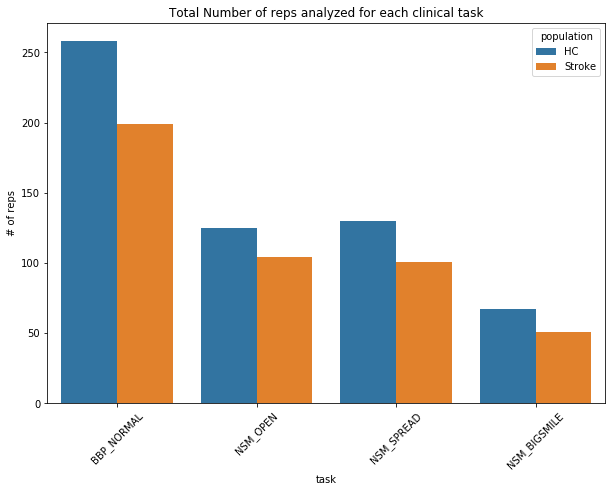

In [27]:
# TASKS 
ax, figure = plt.subplots(figsize=(10,7))
g = sns.countplot(x='task',data=stroke_df,hue='population')
g.set_xticklabels(g.get_xticklabels(), rotation=45)

# set axes labels and title
plt.ylabel('# of reps')
plt.title('Total Number of reps analyzed for each clinical task')
plt.show()

# Getting the corrolations based on the common data with clinical scores 

In [28]:
slp_scores

,File Name,Subject ID,Symmetry (SLP1),ROM (SLP1),Speed (SLP1),Variability (SLP1),Fatigue (SLP1),Tot (SLP1),Symmetry (SLP2),ROM (SLP2),...,Fatigue (SLP2),Tot (SLP2),Tot_avg,Symmetry_avg,ROM_avg,Speed_avg,Variability_avg,Fatigue_avg,task,population
0,A002_02_BBP_NORMAL_color.avi,A002,1,1,1,1,1,5,2,1,...,1,6,5.5,1.5,1.0,1.0,1.0,1.0,BBP_NORMAL,ALS
1,A002_02_DDK_PATAKA_color.avi,A002,1,1,1,1,1,5,2,2,...,2,9,7.0,1.5,1.5,1.0,1.5,1.5,PATAKA,ALS
2,A002_02_DDK_PA_color.avi,A002,1,1,1,1,1,5,2,2,...,2,9,7.0,1.5,1.5,1.0,1.5,1.5,PA,ALS
3,A002_02_NSM_BLOW_color.avi,A002,2,1,1,2,1,7,1,2,...,1,8,7.5,1.5,1.5,1.5,2.0,1.0,BLOW,ALS
4,A002_02_NSM_KISS_color.avi,A002,2,1,1,1,4,9,1,1,...,3,7,8.0,1.5,1.0,1.0,1.0,3.5,KISS,ALS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,N019_02_NSM_BIGSMILE_color.avi,NF19,1,2,2,1,1,7,2,2,...,1,9,8.0,1.5,2.0,2.0,1.5,1.0,NSM_BIGSMILE,HC
257,N019_02_NSM_BROW_color.avi,NF19,1,1,1,1,1,5,1,1,...,1,5,5.0,1.0,1.0,1.0,1.0,1.0,BROW,HC
258,N019_02_NSM_KISS_color.avi,NF19,2,1,2,2,1,8,2,1,...,1,6,7.0,2.0,1.0,1.5,1.5,1.0,KISS,HC
259,N019_02_NSM_OPEN_color.avi,NF19,2,1,1,1,1,6,2,1,...,1,6,6.0,2.0,1.0,1.0,1.0,1.0,NSM_OPEN,HC


In [29]:
stroke_df

,subject_id,task,type,rep,O_MAX,O_MIN,O_MAX_VEL,O_MIN_VEL,W_MAX,W_MIN,W_MAX_VEL,W_MIN_VEL,A_MOUTH,R_LCRC,D_0,D_1,D_2,D_3,population
0,NF11,BBP_NORMAL,0,1,2.286921,1.022002,0.594900,-0.544603,1.077094,0.876171,0.119329,-0.104292,2.098207,0.215262,0.975132,1.049206,0.568557,1.173047,HC
1,NF11,BBP_NORMAL,0,2,2.188607,0.996711,0.820745,-0.436266,1.044838,0.870372,0.095685,-0.054182,1.825080,0.091104,1.491866,0.899794,0.533262,1.128183,HC
2,NF11,BBP_NORMAL,0,3,2.058023,1.047133,0.769061,-0.903222,1.022509,0.865620,0.047249,-0.049228,1.695076,0.367979,1.359297,0.993397,0.818813,1.007924,HC
3,NF11,BBP_NORMAL,0,4,2.075979,1.042164,1.059445,-0.647830,1.027606,0.885372,0.059202,-0.064426,2.170755,0.170831,0.910991,0.902072,0.835538,1.109912,HC
4,NF11,BBP_NORMAL,0,5,1.981968,1.005337,0.676766,-0.322046,1.134544,0.922301,0.114083,-0.139226,2.475245,0.445453,1.032537,1.729688,0.614693,0.953813,HC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1030,OP12,NSM_BIGSMILE,1,2,2.282541,1.061147,0.344813,-0.450737,1.161889,0.921585,0.069482,-0.062309,0.446986,0.709414,0.451040,0.641630,0.568999,0.182978,Stroke
1031,OP12,NSM_BIGSMILE,1,3,2.312239,0.882754,0.285141,-0.597008,1.183347,0.959490,0.055466,-0.032090,0.761721,0.711964,0.495153,0.634551,0.835128,0.283635,Stroke
1032,OP12,NSM_BIGSMILE,1,4,2.470416,0.788574,0.434552,-0.269388,1.221970,0.975984,0.059636,-0.090459,0.702514,0.646163,0.479837,0.992150,1.111108,0.242134,Stroke
1033,OP12,NSM_BIGSMILE,1,5,1.800105,0.723599,0.399001,-0.229730,1.162125,0.993194,0.037345,-0.029130,0.754221,0.522847,0.389142,0.697274,1.106518,0.314343,Stroke


In [36]:
stroke_and_scores = stroke_df.merge(slp_scores, how= 'inner', left_on=['subject_id', 'task'], right_on=['Subject ID', 'task'])

print(len(stroke_and_scores.subject_id.unique()))
print(stroke_and_scores.subject_id.unique())
print(stroke_and_scores.task.unique())

print(stroke_df.shape)
print(stroke_and_scores.shape)
print(stroke_and_scores.columns)

23
['NF11' 'NF12' 'NF17' 'NF19' 'NF02' 'NF03' 'NF04' 'NF07' 'NF08' 'NF10'
 'OP01' 'OP02' 'OP03' 'S001' 'S002' 'S003' 'S005' 'S006' 'S007' 'S008'
 'S009' 'S013' 'NF01']
['BBP_NORMAL' 'NSM_OPEN' 'NSM_SPREAD' 'NSM_BIGSMILE']
(1035, 19)
(481, 40)
Index(['subject_id', 'task', 'type', 'rep', 'O_MAX', 'O_MIN', 'O_MAX_VEL',
       'O_MIN_VEL', 'W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL', 'A_MOUTH',
       'R_LCRC', 'D_0', 'D_1', 'D_2', 'D_3', 'population_x', 'File Name',
       'Subject ID', 'Symmetry (SLP1)', 'ROM (SLP1)', 'Speed (SLP1)',
       'Variability (SLP1)', 'Fatigue (SLP1)', 'Tot (SLP1)', 'Symmetry (SLP2)',
       'ROM (SLP2)', 'Speed (SLP2)', 'Variability (SLP2)', 'Fatigue (SLP2)',
       'Tot (SLP2)', 'Tot_avg', 'Symmetry_avg', 'ROM_avg', 'Speed_avg',
       'Variability_avg', 'Fatigue_avg', 'population_y'],
      dtype='object')


Spearmans correlation between O_MAX and ROM_avg: -0.378
Spearmans correlation between O_MIN and ROM_avg: -0.162
Spearmans correlation between O_MAX_VEL and ROM_avg: -0.409
Spearmans correlation between O_MIN_VEL and ROM_avg: 0.333
Spearmans correlation between W_MAX and ROM_avg: 0.069
Spearmans correlation between W_MIN and ROM_avg: 0.172
Spearmans correlation between W_MAX_VEL and ROM_avg: -0.299
Spearmans correlation between W_MIN_VEL and ROM_avg: 0.254
Spearmans correlation between A_MOUTH and ROM_avg: -0.234
Spearmans correlation between R_LCRC and ROM_avg: -0.372
Spearmans correlation between D_0 and ROM_avg: 0.022


<ipython-input-46-e8153c8c75ac>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
<ipython-input-46-e8153c8c75ac>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  ax, figure = plt.subplots(figsize=(10,7))


Spearmans correlation between D_1 and ROM_avg: -0.006
Spearmans correlation between D_2 and ROM_avg: 0.245
Spearmans correlation between D_3 and ROM_avg: -0.083


<Figure size 432x288 with 0 Axes>

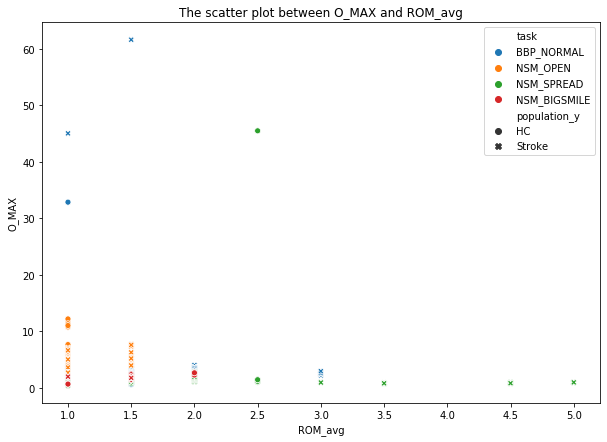

<Figure size 432x288 with 0 Axes>

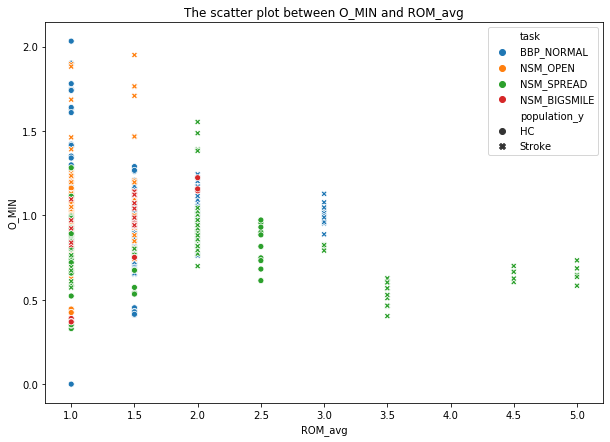

<Figure size 432x288 with 0 Axes>

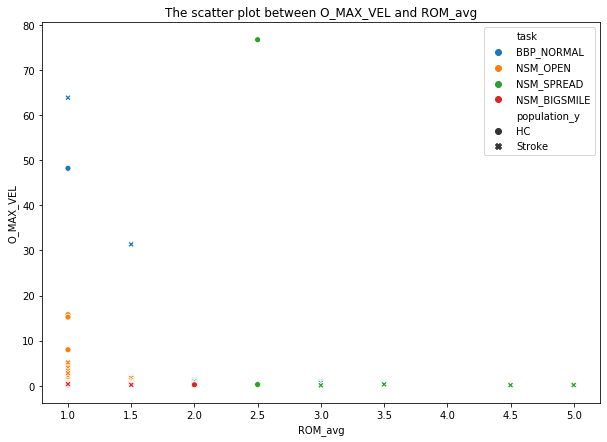

<Figure size 432x288 with 0 Axes>

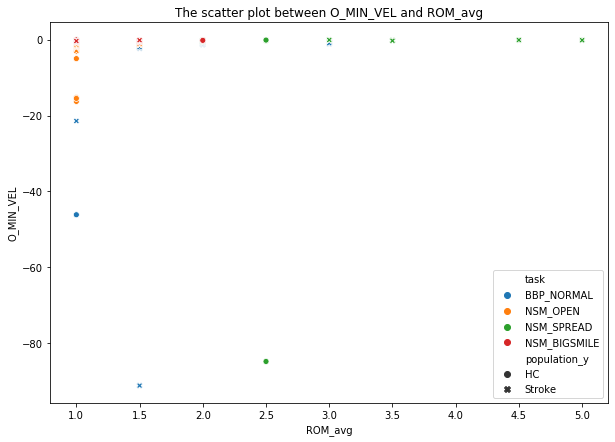

<Figure size 432x288 with 0 Axes>

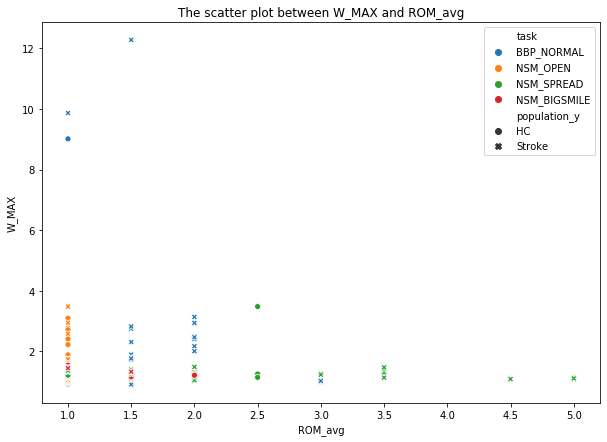

<Figure size 432x288 with 0 Axes>

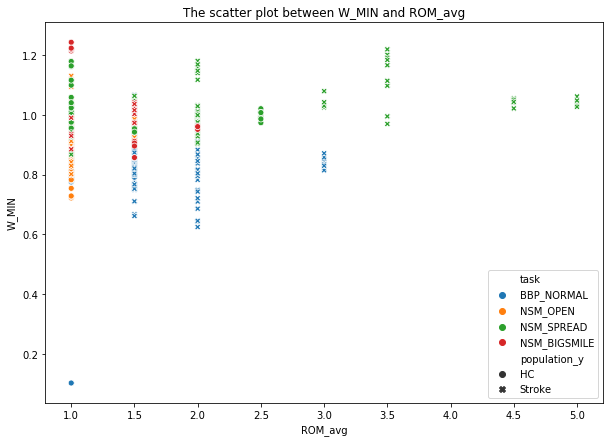

<Figure size 432x288 with 0 Axes>

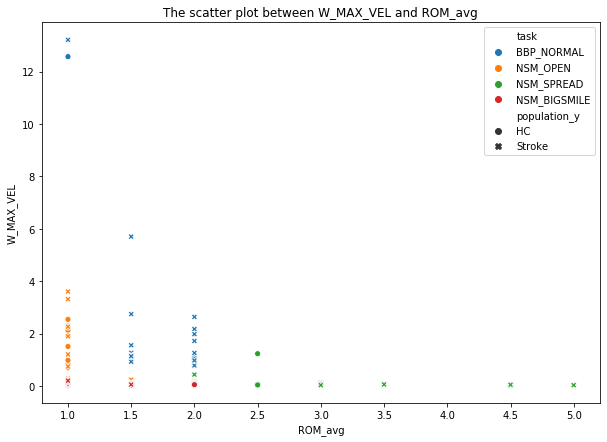

<Figure size 432x288 with 0 Axes>

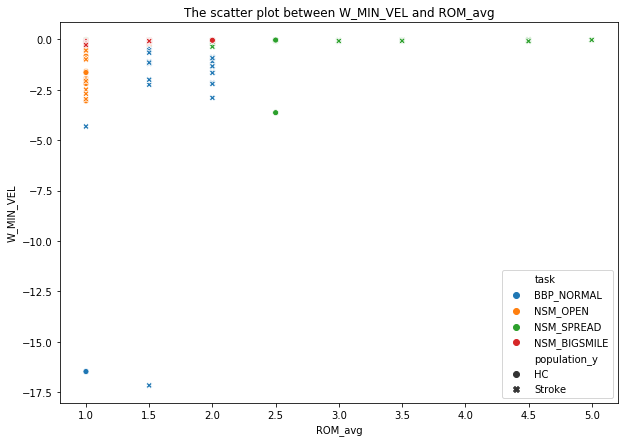

<Figure size 432x288 with 0 Axes>

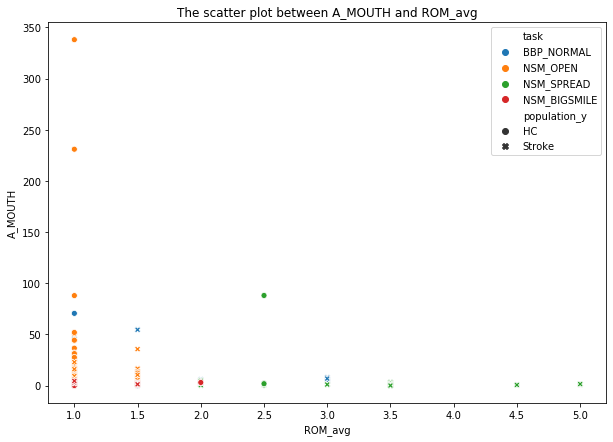

<Figure size 432x288 with 0 Axes>

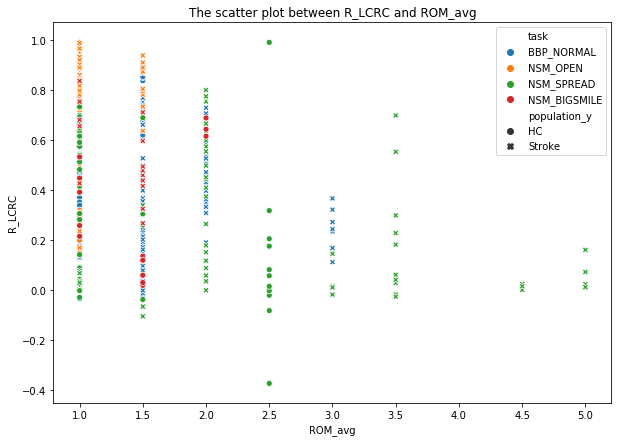

<Figure size 432x288 with 0 Axes>

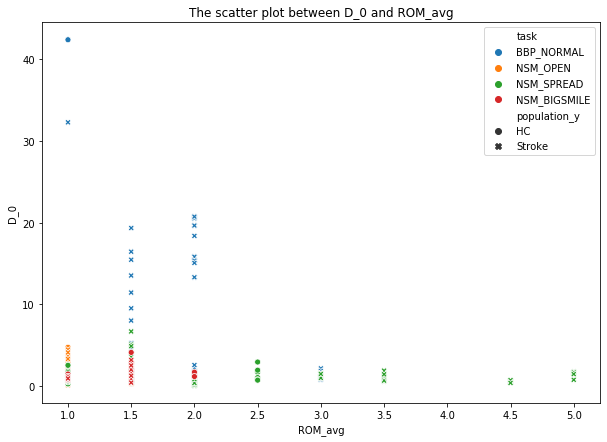

<Figure size 432x288 with 0 Axes>

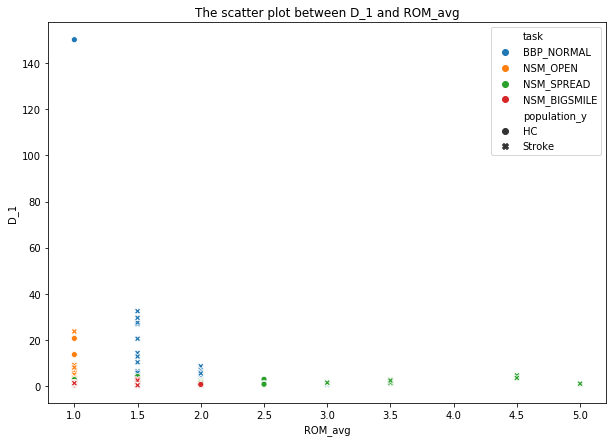

<Figure size 432x288 with 0 Axes>

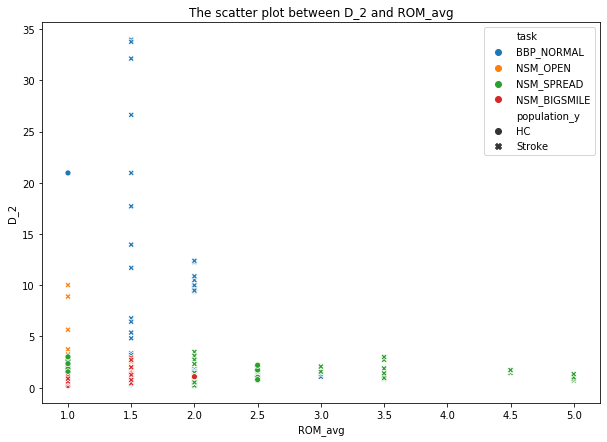

<Figure size 432x288 with 0 Axes>

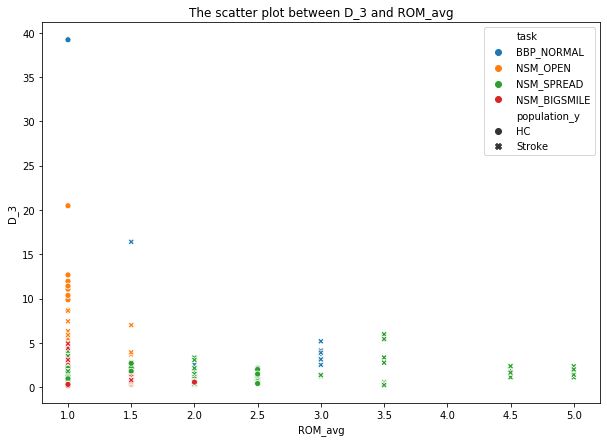

In [46]:
# raw data corrolations and scatter plots between each feature and a single clinical score 

stroke_features = ['O_MAX', 'O_MIN','O_MAX_VEL', 'O_MIN_VEL', 'W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL',
       'A_MOUTH', 'R_LCRC', 'D_0', 'D_1', 'D_2', 'D_3']

for f in stroke_features:
    plt.figure()
    ax, figure = plt.subplots(figsize=(10,7))
    score = 'ROM_avg'
    sns.scatterplot(x=score, y=f, data=stroke_and_scores, hue='task', style='population_y')
    plt.title('The scatter plot between {} and {}'.format(f, score ))

    # calculate spearman's correlation
    corr, _ = spearmanr(stroke_and_scores[f], stroke_and_scores[score])
    print('Spearmans correlation between {} and {}: %.3f'.format(f, score) % corr)

In [51]:
# filtering out the outliers 

z_scores = stats.zscore(stroke_and_scores[['O_MAX', 'O_MIN','O_MAX_VEL', 'O_MIN_VEL', 'W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL',
       'A_MOUTH', 'R_LCRC', 'D_0', 'D_1', 'D_2', 'D_3']])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
new_stroke_and_scores = stroke_and_scores[filtered_entries]

print(new_stroke_and_scores.shape)

(442, 40)


Spearmans correlation between O_MAX and ROM_avg: -0.397
Spearmans correlation between O_MIN and ROM_avg: -0.162
Spearmans correlation between O_MAX_VEL and ROM_avg: -0.442
Spearmans correlation between O_MIN_VEL and ROM_avg: 0.374
Spearmans correlation between W_MAX and ROM_avg: 0.047
Spearmans correlation between W_MIN and ROM_avg: 0.222
Spearmans correlation between W_MAX_VEL and ROM_avg: -0.381
Spearmans correlation between W_MIN_VEL and ROM_avg: 0.314
Spearmans correlation between A_MOUTH and ROM_avg: -0.234
Spearmans correlation between R_LCRC and ROM_avg: -0.412


<ipython-input-52-b78b08808ad0>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
<ipython-input-52-b78b08808ad0>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  ax, figure = plt.subplots(figsize=(10,7))


Spearmans correlation between D_0 and ROM_avg: -0.035
Spearmans correlation between D_1 and ROM_avg: -0.046
Spearmans correlation between D_2 and ROM_avg: 0.202
Spearmans correlation between D_3 and ROM_avg: -0.062


<Figure size 432x288 with 0 Axes>

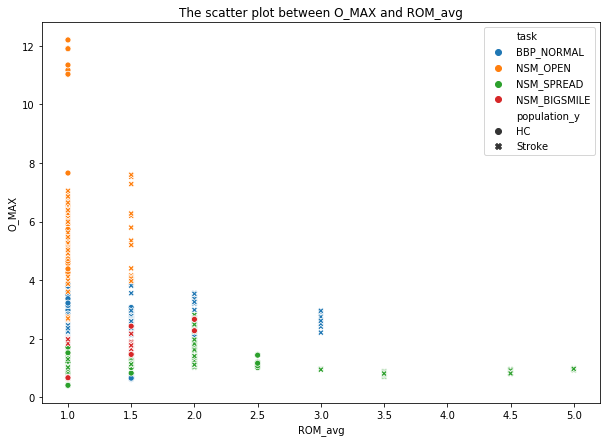

<Figure size 432x288 with 0 Axes>

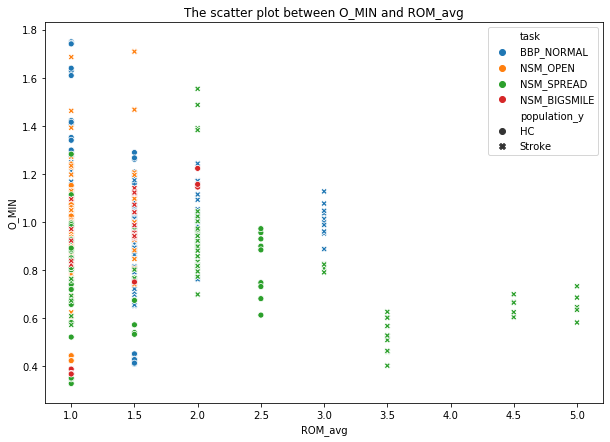

<Figure size 432x288 with 0 Axes>

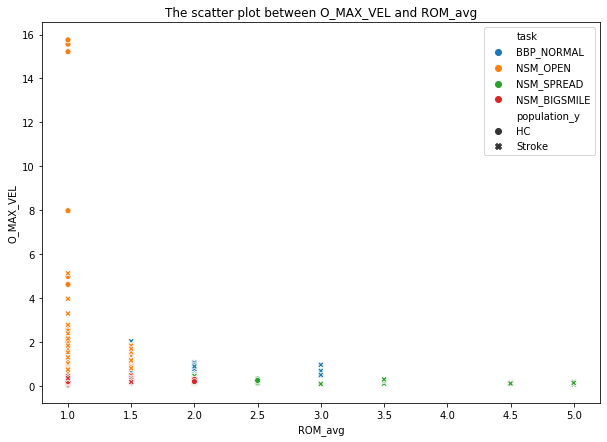

<Figure size 432x288 with 0 Axes>

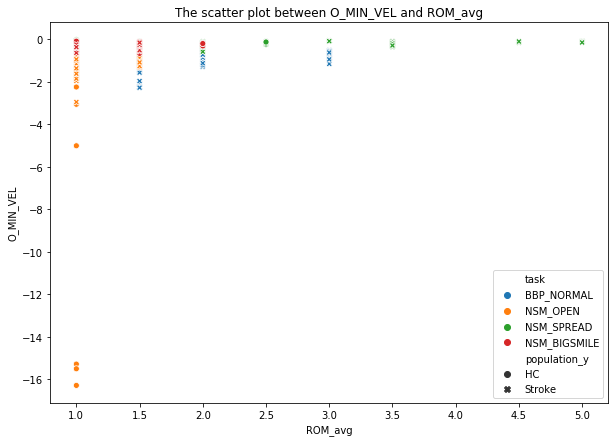

<Figure size 432x288 with 0 Axes>

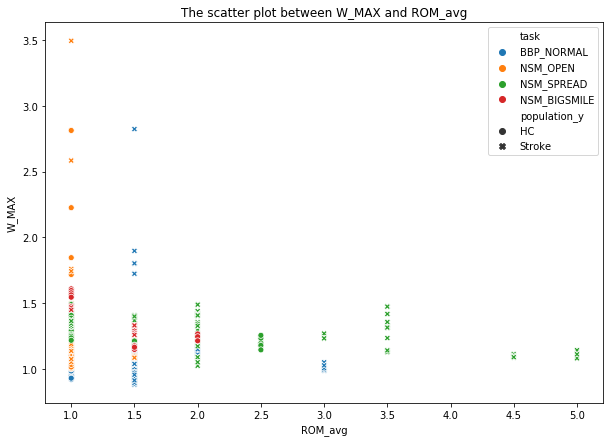

<Figure size 432x288 with 0 Axes>

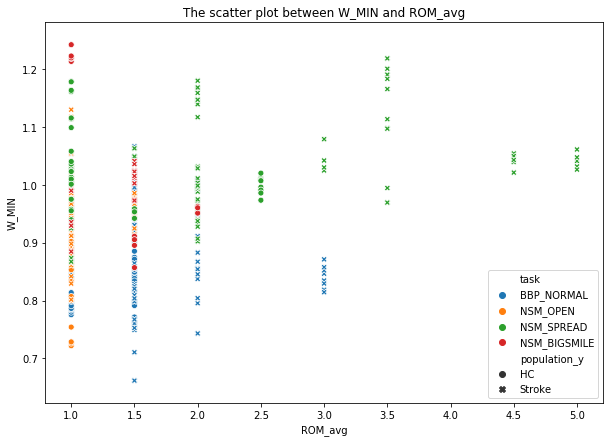

<Figure size 432x288 with 0 Axes>

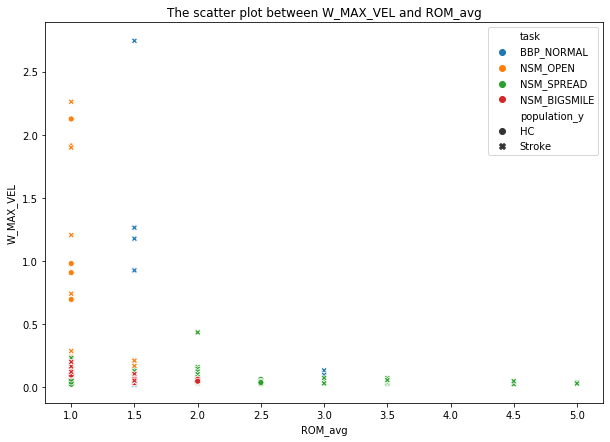

<Figure size 432x288 with 0 Axes>

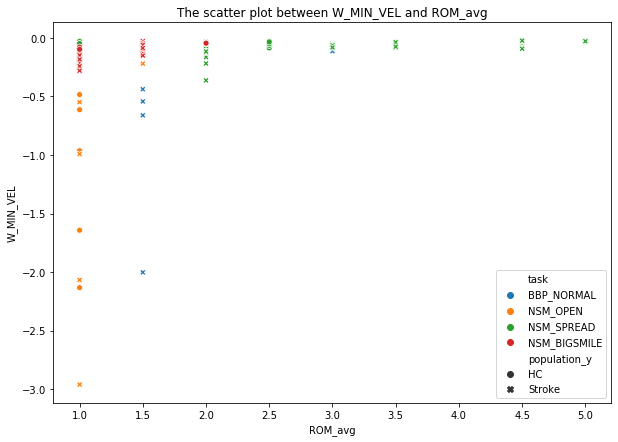

<Figure size 432x288 with 0 Axes>

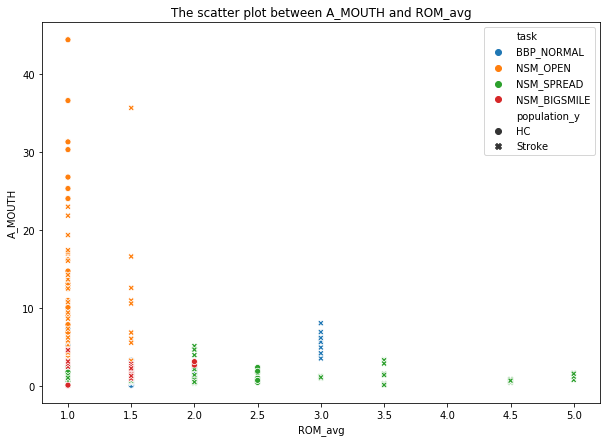

<Figure size 432x288 with 0 Axes>

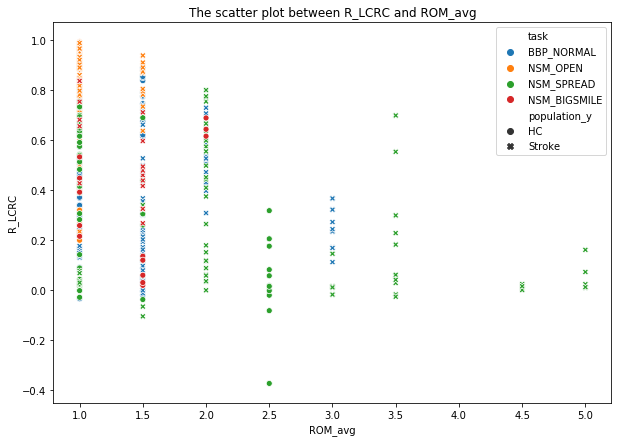

<Figure size 432x288 with 0 Axes>

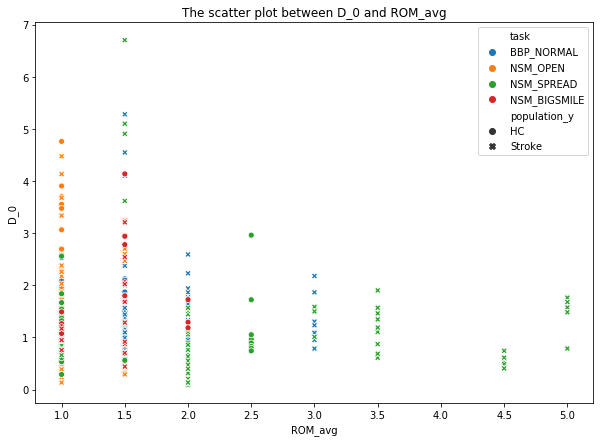

<Figure size 432x288 with 0 Axes>

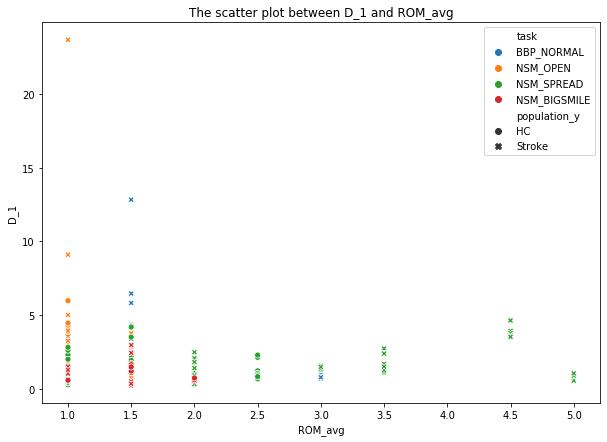

<Figure size 432x288 with 0 Axes>

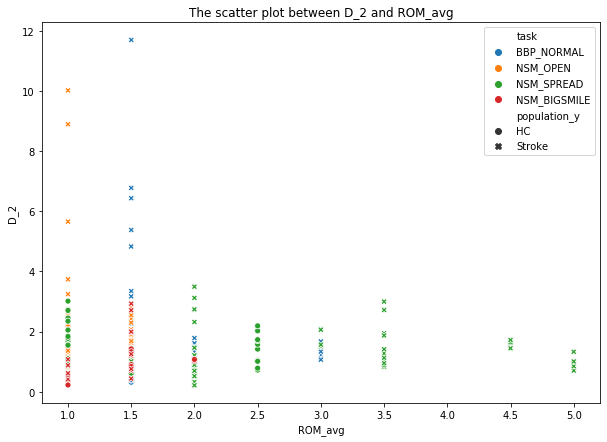

<Figure size 432x288 with 0 Axes>

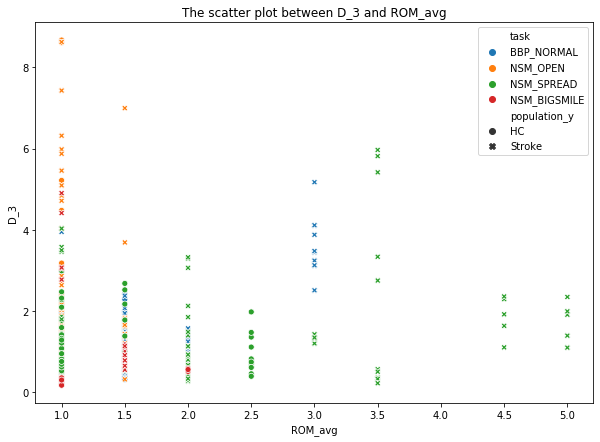

In [52]:
# outliers removed scatter plot and corrolations between each feature and a single clinical score 
for f in stroke_features:
    plt.figure()
    ax, figure = plt.subplots(figsize=(10,7))
    score = 'ROM_avg'
    sns.scatterplot(x=score, y=f, data=new_stroke_and_scores, hue='task', style='population_y')
    plt.title('The scatter plot between {} and {}'.format(f, score ))

    # calculate spearman's correlation
    corr, _ = spearmanr(new_stroke_and_scores[f], new_stroke_and_scores[score])
    print('Spearmans correlation between {} and {}: %.3f'.format(f, score) % corr)

### Diego ALS DATA 

In [54]:
### ALS DATA
tasks = ['BBP_NORMAL', 'NSM_OPEN', 'NSM_SPREAD', 'NSM_BIGSMILE']
task = 0# 0-> NORMAL_BBP, 1-> NSM_OPEN, 2-> NSM_SPREAD, 3->NSM_BIGSMILE
als_file_1 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/ALS_vs_Controls_database_finetuned/metric_output_"+tasks[task]+".csv"
als_file_2 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/ALS_vs_Controls_new_finetuned/metric_output_"+tasks[task]+".csv"
als_file_3 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/ALS_vs_Controls_old_finetuned/metric_output_"+tasks[task]+".csv"


bbp_als_df_1 = pd.read_csv(als_file_1)
bbp_als_df_1 = bbp_als_df_1.drop('Unnamed: 0', axis=1)
print_prop(bbp_als_df_1, als_file_1)


bbp_als_df_2 = pd.read_csv(als_file_2)
bbp_als_df_2 = bbp_als_df_2.drop('Unnamed: 0', axis=1)
print_prop(bbp_als_df_2, als_file_2)


bbp_als_df_3 = pd.read_csv(als_file_3)
bbp_als_df_3 = bbp_als_df_3.drop('Unnamed: 0', axis=1)
print_prop(bbp_als_df_3, als_file_3)



/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/ALS_vs_Controls_database_finetuned/metric_output_BBP_NORMAL.csv
Shape:  (164, 20)

Index(['subject_id', 'task', 'type', 'rep', 'LL_PATH', 'A_MEAN', 'A_RANGE',
       'A_ABS_DIFF', 'A_CCC', 'WIDTH_MAX', 'WIDTH_MEAN', 'WIDTH_VEL_MAX',
       'WIDTH_VEL_MIN', 'HEIGHT_MAX', 'HEIGHT_MIN', 'HEIGHT_VEL_MAX',
       'HEIGHT_VEL_MIN', 'R_SYMM', 'E_MEAN', 'E_RANGE'],
      dtype='object')

Total Number of Subjects in Df are:  16
Subjects IDs are:  ['A001' 'A004' 'A008' 'A009' 'A010' 'A011' 'NF11' 'NF12' 'NF17' 'NF18'
 'NF02' 'NF03' 'NF04' 'NF07' 'NF08' 'NF10']

/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/ALS_vs_Controls_new_finetuned/metric_output_BBP_NORMAL.csv
Shape:  (194, 20)

Index(['subject_id', 'task', 'type', 'rep', 'LL_PATH', 'A_MEAN', 'A_RANGE',
       'A_ABS_DIFF', 'A_CCC', 'WIDTH_MAX', 'WIDTH_MEAN', 'WIDTH_VEL_MAX',
       'WIDTH_VEL_MIN', 'HEIGHT_MAX', 'HEIGHT_MIN', 'HEIGHT_VEL_MAX',
       'HEIG

In [56]:
print('3 includes 1: ', set(bbp_als_df_1.subject_id.unique()).issubset(bbp_als_df_3.subject_id.unique()))

print('2 includes 1: ', set(bbp_als_df_1.subject_id.unique()).issubset(bbp_als_df_2.subject_id.unique()))

print(bbp_als_df_1.subject_id.unique())
print(bbp_als_df_2.subject_id.unique())
print(bbp_als_df_3.subject_id.unique())

3 includes 1:  False
2 includes 1:  False
['A001' 'A004' 'A008' 'A009' 'A010' 'A011' 'NF11' 'NF12' 'NF17' 'NF18'
 'NF02' 'NF03' 'NF04' 'NF07' 'NF08' 'NF10']
['A013' 'A014' 'A016' 'A017' 'NF11' 'NF12' 'NF13' 'NF14' 'NF15' 'NF16'
 'NF17' 'NF18' 'NF19' 'NF20' 'NF21' 'NF22' 'NF24' 'NF26' 'NF27']
['A001' 'A004' 'A005' 'A007' 'A008' 'A009' 'A010' 'A011' 'NF00' 'NF02'
 'NF03' 'NF04' 'NF05' 'NF06' 'NF07' 'NF08' 'NF09' 'NF10']


In [ ]:
bbp_als_df_1.loc[bbp_als_df_1['subject_id'] == 'A008']

In [ ]:
bbp_als_df_3.loc[bbp_als_df_3['subject_id'] == 'A008']

In [ ]:
diego_bbp = bbp_als_df_1.merge(bbp_als_df_2)
diego_bbp = diego_bbp.merge(bbp_als_df_3)
uncommon_1 = bbp_als_df_1.loc[~bbp_als_df_1.subject_id.isin(diego_bbp.subject_id)]
uncommon_2 = bbp_als_df_2.loc[~bbp_als_df_2.subject_id.isin(diego_bbp.subject_id)]
uncommon_3 = bbp_als_df_3.loc[~bbp_als_df_3.subject_id.isin(diego_bbp.subject_id)]

print('shapes: ',uncommon_1.shape, uncommon_2.shape, uncommon_3.shape)

diego_bbp = pd.concat([diego_bbp, uncommon_1, uncommon_2, uncommon_3], ignore_index=True)

print_prop(diego_bbp, als_file_3)

In [57]:
als_df = pd.DataFrame()

for task in range(len(tasks)):
    als_file_1 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/ALS_vs_Controls_database_finetuned/metric_output_"+tasks[task]+".csv"
    als_file_2 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/ALS_vs_Controls_new_finetuned/metric_output_"+tasks[task]+".csv"
    als_file_3 = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/ALS_vs_Controls_old_finetuned/metric_output_"+tasks[task]+".csv"
    
    try: 
        als_df_1 = pd.read_csv(als_file_1)
    except:
        pass
    try:
        als_df_2 = pd.read_csv(als_file_2)
    except:
        pass
    try:
        als_df_3 = pd.read_csv(als_file_3)
    except:
        pass
    als_df = pd.concat([als_df, als_df_1, als_df_2, als_df_3], ignore_index=True)



    
print(als_df.shape)


(1278, 21)


In [58]:
als_df = als_df.drop_duplicates()

als_df = als_df.drop('Unnamed: 0', axis=1)

In [59]:
als_df['population'] = [pop_labeler(x) for x in als_df['subject_id']]

In [67]:
print(als_df.shape)
print(als_df.columns)
print(als_df.task.unique())
print(als_df.subject_id.unique())
print(len(als_df.subject_id.unique()))
print(len(als_df.groupby(['population']).subject_id.unique()['ALS']))
print(len(als_df.groupby(['population']).subject_id.unique()['HC']))
print(als_df.groupby(['population']).subject_id.unique()['ALS'])
print(als_df.groupby(['population']).subject_id.unique()['HC'])

(1143, 21)
Index(['subject_id', 'task', 'type', 'rep', 'LL_PATH', 'A_MEAN', 'A_RANGE',
       'A_ABS_DIFF', 'A_CCC', 'WIDTH_MAX', 'WIDTH_MEAN', 'WIDTH_VEL_MAX',
       'WIDTH_VEL_MIN', 'HEIGHT_MAX', 'HEIGHT_MIN', 'HEIGHT_VEL_MAX',
       'HEIGHT_VEL_MIN', 'R_SYMM', 'E_MEAN', 'E_RANGE', 'population'],
      dtype='object')
['BBP_NORMAL' 'NSM_OPEN' 'NSM_SPREAD' 'NSM_BIGSMILE']
['A001' 'A004' 'A008' 'A009' 'A010' 'A011' 'NF11' 'NF12' 'NF17' 'NF18'
 'NF02' 'NF03' 'NF04' 'NF07' 'NF08' 'NF10' 'A013' 'A014' 'A016' 'A017'
 'NF13' 'NF14' 'NF15' 'NF16' 'NF19' 'NF20' 'NF21' 'NF22' 'NF24' 'NF26'
 'NF27' 'A005' 'A007' 'NF00' 'NF05' 'NF06' 'NF09' 'NF01' 'AF18']
39
13
26
['A001' 'A004' 'A008' 'A009' 'A010' 'A011' 'A013' 'A014' 'A016' 'A017'
 'A005' 'A007' 'AF18']
['NF11' 'NF12' 'NF17' 'NF18' 'NF02' 'NF03' 'NF04' 'NF07' 'NF08' 'NF10'
 'NF13' 'NF14' 'NF15' 'NF16' 'NF19' 'NF20' 'NF21' 'NF22' 'NF24' 'NF26'
 'NF27' 'NF00' 'NF05' 'NF06' 'NF09' 'NF01']


In [62]:
# Print the needed info 

print(np.intersect1d(als_df.subject_id.unique(),neuroface_subjects))
print(len(np.intersect1d(als_df.subject_id.unique(),neuroface_subjects)))

['A008' 'A009' 'A010' 'A011' 'A014' 'A016' 'A017' 'NF01' 'NF02' 'NF03'
 'NF04' 'NF07' 'NF08' 'NF10' 'NF11' 'NF12' 'NF17' 'NF19']
18


In [68]:
als_df

,subject_id,task,type,rep,LL_PATH,A_MEAN,A_RANGE,A_ABS_DIFF,A_CCC,WIDTH_MAX,...,WIDTH_VEL_MAX,WIDTH_VEL_MIN,HEIGHT_MAX,HEIGHT_MIN,HEIGHT_VEL_MAX,HEIGHT_VEL_MIN,R_SYMM,E_MEAN,E_RANGE,population
0,A001,BBP_NORMAL,1,1,110.844863,1.963936,1.891808,1.211720,0.963126,0.996882,...,0.047575,-0.048142,2.654441,0.971953,1.560978,-1.037405,0.789088,0.915388,0.147840,ALS
1,A001,BBP_NORMAL,1,2,104.091810,1.971747,1.957019,0.990572,0.966934,1.010081,...,0.053499,-0.072361,2.889632,1.049102,1.719019,-0.651698,0.770903,0.909355,0.184874,ALS
2,A001,BBP_NORMAL,1,3,102.911022,1.984549,2.110940,0.984344,0.970458,1.028645,...,0.046834,-0.079407,2.893775,0.976790,1.991129,-1.199396,0.808824,0.914979,0.183038,ALS
3,A001,BBP_NORMAL,1,4,114.565343,1.993282,2.058110,1.168021,0.962153,1.028064,...,0.055824,-0.065788,2.901614,1.059788,1.630563,-1.412092,0.801370,0.917676,0.169006,ALS
4,A001,BBP_NORMAL,1,5,111.400247,1.927718,2.121415,1.045818,0.968644,1.047127,...,0.045098,-0.069668,2.826851,0.959418,0.982310,-0.994023,0.719866,0.920459,0.165879,ALS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1179,NF27,NSM_BIGSMILE,0,1,37.416241,1.742545,1.323195,0.382680,0.979688,1.435127,...,0.067678,-0.053022,1.620111,0.784574,0.330147,-0.392683,0.929587,0.972750,0.035968,HC
1180,NF27,NSM_BIGSMILE,0,2,47.668871,1.284062,0.647781,0.262910,0.958671,1.474387,...,0.055002,-0.101244,1.105807,0.635744,0.516713,-0.246063,0.568664,0.985373,0.018874,HC
1181,NF27,NSM_BIGSMILE,0,3,53.903182,1.328058,0.779607,0.410098,0.909053,1.481821,...,0.063939,-0.068264,1.371135,0.706191,0.433787,-0.374990,0.769234,0.982066,0.033532,HC
1182,NF27,NSM_BIGSMILE,0,4,56.234051,1.262346,0.527161,0.493376,0.821861,1.417756,...,0.078527,-0.061075,1.300910,0.689997,0.268302,-0.210019,0.815927,0.980362,0.034358,HC


In [69]:
als_and_scores = als_df.merge(slp_scores, how= 'inner', left_on=['subject_id', 'task'], right_on=['Subject ID', 'task'])

print(len(als_and_scores.subject_id.unique()))
print(als_and_scores.subject_id.unique())
print(als_and_scores.task.unique())

print(als_df.shape)
print(als_and_scores.shape)
print(als_and_scores.columns)

18
['A008' 'A009' 'A010' 'A011' 'NF11' 'NF12' 'NF17' 'NF02' 'NF03' 'NF04'
 'NF07' 'NF08' 'NF10' 'A014' 'A016' 'A017' 'NF19' 'NF01']
['BBP_NORMAL' 'NSM_OPEN' 'NSM_SPREAD' 'NSM_BIGSMILE']
(1143, 21)
(650, 42)
Index(['subject_id', 'task', 'type', 'rep', 'LL_PATH', 'A_MEAN', 'A_RANGE',
       'A_ABS_DIFF', 'A_CCC', 'WIDTH_MAX', 'WIDTH_MEAN', 'WIDTH_VEL_MAX',
       'WIDTH_VEL_MIN', 'HEIGHT_MAX', 'HEIGHT_MIN', 'HEIGHT_VEL_MAX',
       'HEIGHT_VEL_MIN', 'R_SYMM', 'E_MEAN', 'E_RANGE', 'population_x',
       'File Name', 'Subject ID', 'Symmetry (SLP1)', 'ROM (SLP1)',
       'Speed (SLP1)', 'Variability (SLP1)', 'Fatigue (SLP1)', 'Tot (SLP1)',
       'Symmetry (SLP2)', 'ROM (SLP2)', 'Speed (SLP2)', 'Variability (SLP2)',
       'Fatigue (SLP2)', 'Tot (SLP2)', 'Tot_avg', 'Symmetry_avg', 'ROM_avg',
       'Speed_avg', 'Variability_avg', 'Fatigue_avg', 'population_y'],
      dtype='object')


Spearmans correlation between LL_PATH and ROM_avg: -0.021
Spearmans correlation between A_MEAN and ROM_avg: -0.280
Spearmans correlation between A_RANGE and ROM_avg: -0.291
Spearmans correlation between A_ABS_DIFF and ROM_avg: -0.084
Spearmans correlation between A_CCC and ROM_avg: -0.121
Spearmans correlation between WIDTH_MAX and ROM_avg: 0.015
Spearmans correlation between WIDTH_MEAN and ROM_avg: 0.167
Spearmans correlation between WIDTH_VEL_MAX and ROM_avg: -0.341
Spearmans correlation between WIDTH_VEL_MIN and ROM_avg: 0.311
Spearmans correlation between HEIGHT_MAX and ROM_avg: -0.316
Spearmans correlation between HEIGHT_MIN and ROM_avg: -0.111


<ipython-input-70-7d17380065ec>:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
<ipython-input-70-7d17380065ec>:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  ax, figure = plt.subplots(figsize=(10,7))


Spearmans correlation between HEIGHT_VEL_MAX and ROM_avg: -0.332
Spearmans correlation between HEIGHT_VEL_MIN and ROM_avg: 0.305
Spearmans correlation between R_SYMM and ROM_avg: -0.195
Spearmans correlation between E_MEAN and ROM_avg: 0.250
Spearmans correlation between E_RANGE and ROM_avg: -0.295


<Figure size 432x288 with 0 Axes>

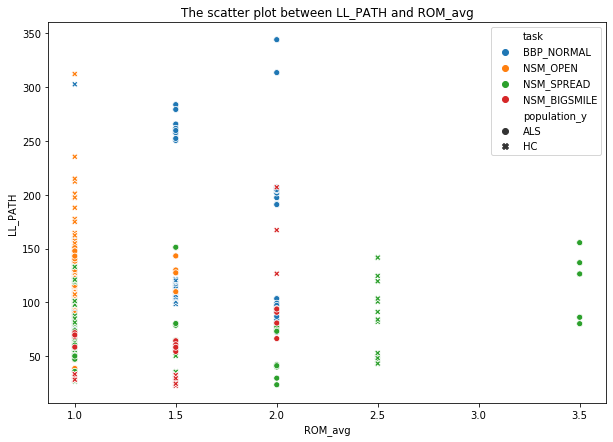

<Figure size 432x288 with 0 Axes>

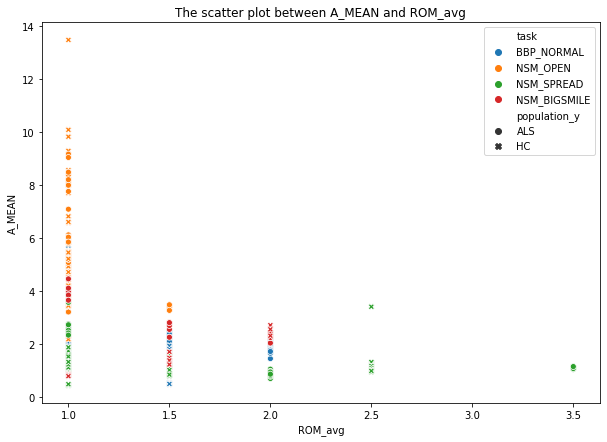

<Figure size 432x288 with 0 Axes>

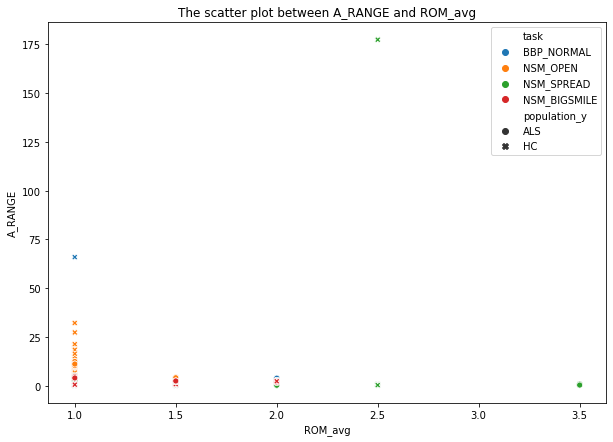

<Figure size 432x288 with 0 Axes>

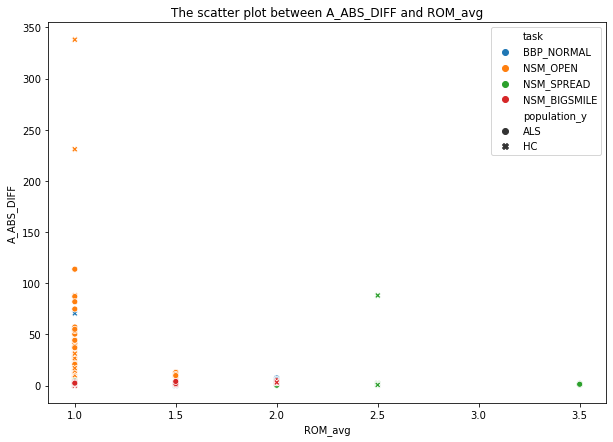

<Figure size 432x288 with 0 Axes>

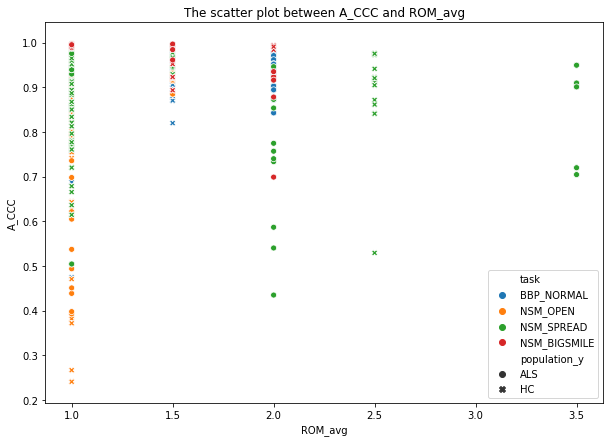

<Figure size 432x288 with 0 Axes>

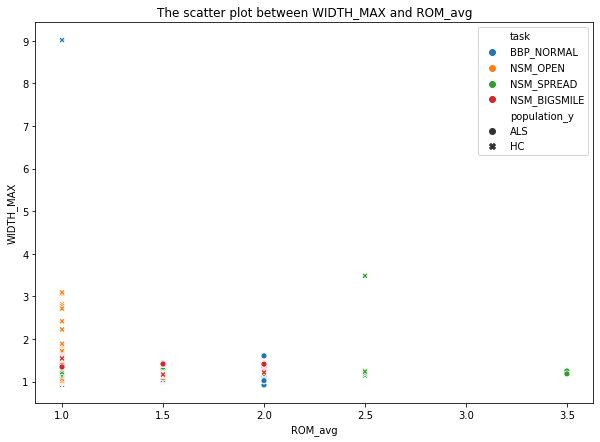

<Figure size 432x288 with 0 Axes>

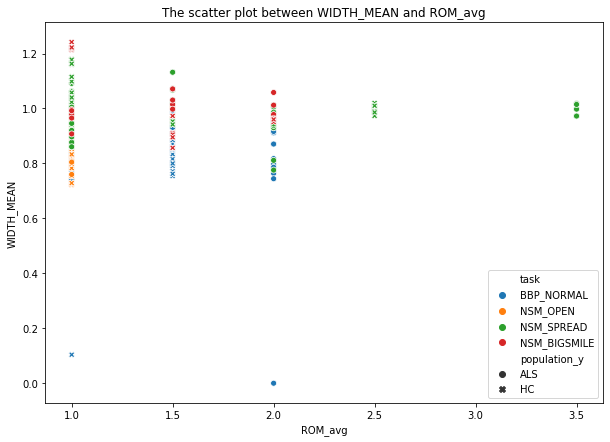

<Figure size 432x288 with 0 Axes>

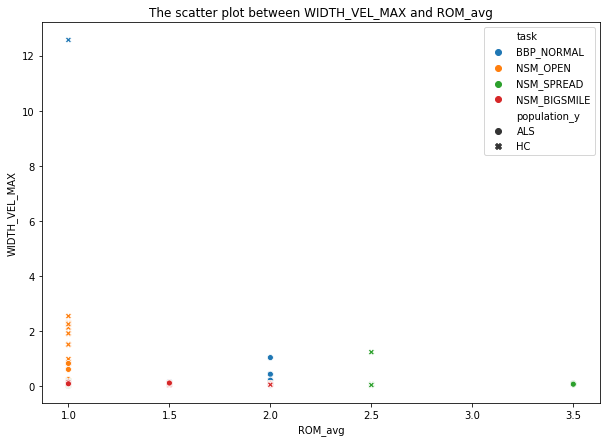

<Figure size 432x288 with 0 Axes>

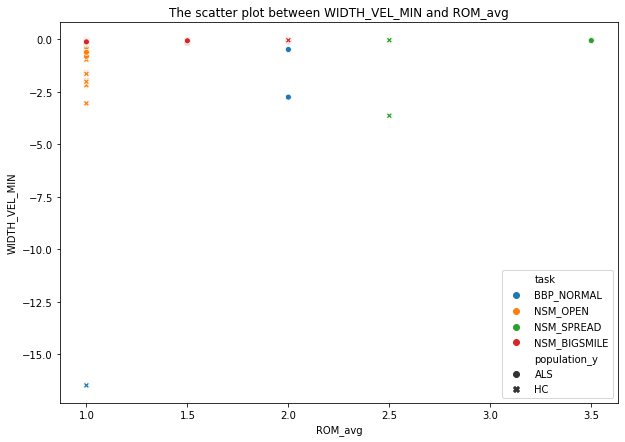

<Figure size 432x288 with 0 Axes>

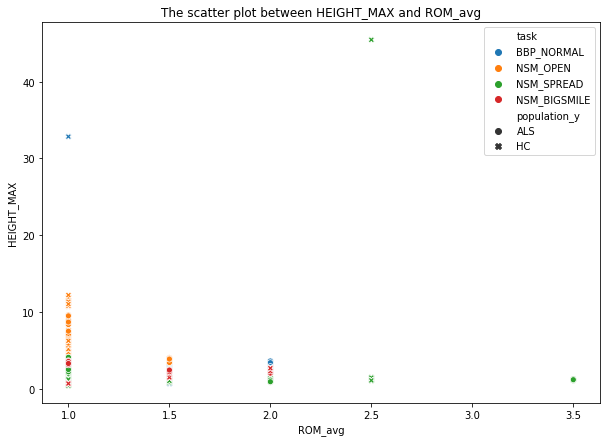

<Figure size 432x288 with 0 Axes>

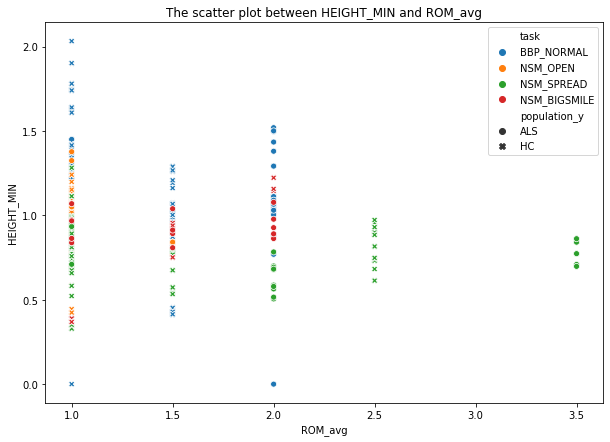

<Figure size 432x288 with 0 Axes>

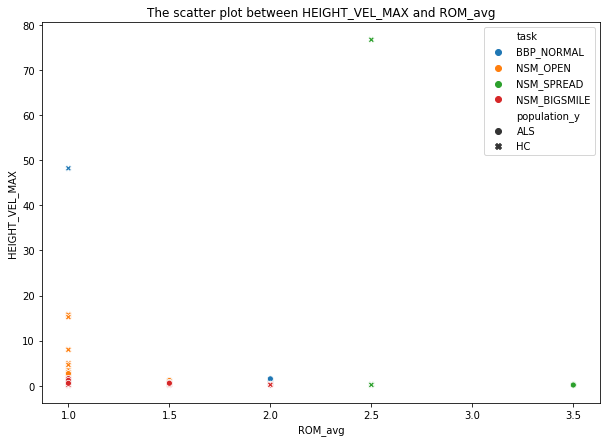

<Figure size 432x288 with 0 Axes>

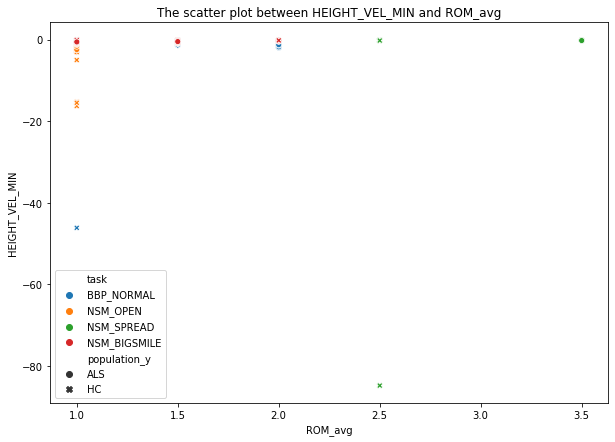

<Figure size 432x288 with 0 Axes>

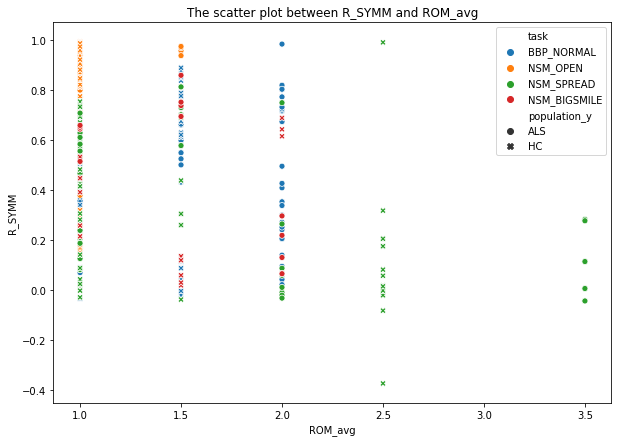

<Figure size 432x288 with 0 Axes>

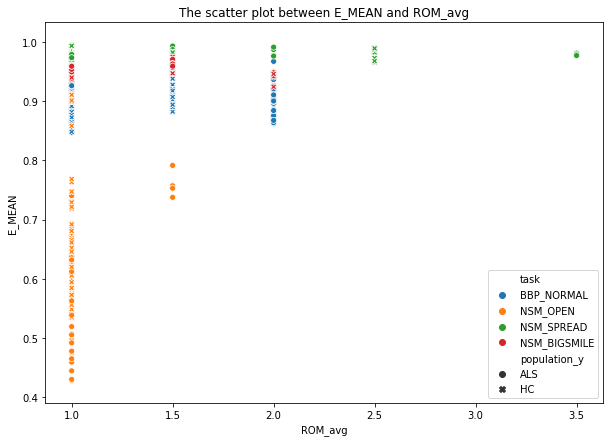

<Figure size 432x288 with 0 Axes>

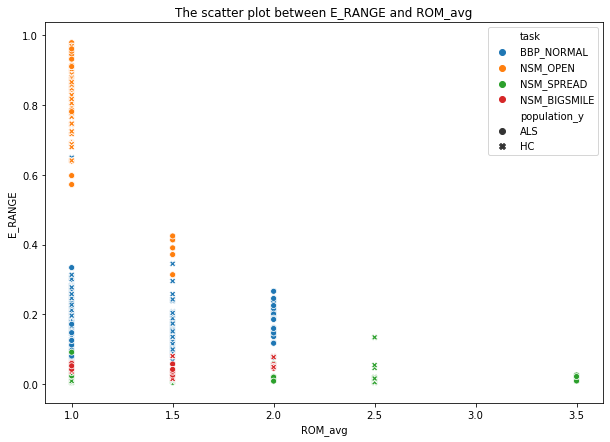

In [70]:
# raw data corrolations and scatter plots between each feature and a single clinical score 

als_features = ['LL_PATH', 'A_MEAN', 'A_RANGE','A_ABS_DIFF', 'A_CCC', 'WIDTH_MAX', 'WIDTH_MEAN', 
                   'WIDTH_VEL_MAX','WIDTH_VEL_MIN', 'HEIGHT_MAX', 'HEIGHT_MIN', 'HEIGHT_VEL_MAX',
       'HEIGHT_VEL_MIN', 'R_SYMM', 'E_MEAN', 'E_RANGE']

for f in als_features:
    plt.figure()
    ax, figure = plt.subplots(figsize=(10,7))
    score = 'ROM_avg'
    sns.scatterplot(x=score, y=f, data=als_and_scores, hue='task', style='population_y')
    plt.title('The scatter plot between {} and {}'.format(f, score ))

    # calculate spearman's correlation
    corr, _ = spearmanr(als_and_scores[f], als_and_scores[score])
    print('Spearmans correlation between {} and {}: %.3f'.format(f, score) % corr)

In [72]:
# filtering out the outliers 

z_scores = stats.zscore(als_and_scores[['LL_PATH', 'A_MEAN', 'A_RANGE','A_ABS_DIFF', 'A_CCC', 'WIDTH_MAX', 'WIDTH_MEAN', 
                   'WIDTH_VEL_MAX','WIDTH_VEL_MIN', 'HEIGHT_MAX', 'HEIGHT_MIN', 'HEIGHT_VEL_MAX',
       'HEIGHT_VEL_MIN', 'R_SYMM', 'E_MEAN', 'E_RANGE']])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
new_als_and_scores = als_and_scores[filtered_entries]

print(new_als_and_scores.shape)

(592, 42)


Spearmans correlation between LL_PATH and ROM_avg: -0.028
Spearmans correlation between A_MEAN and ROM_avg: -0.255
Spearmans correlation between A_RANGE and ROM_avg: -0.288
Spearmans correlation between A_ABS_DIFF and ROM_avg: -0.040
Spearmans correlation between A_CCC and ROM_avg: -0.195
Spearmans correlation between WIDTH_MAX and ROM_avg: 0.040
Spearmans correlation between WIDTH_MEAN and ROM_avg: 0.161
Spearmans correlation between WIDTH_VEL_MAX and ROM_avg: -0.352
Spearmans correlation between WIDTH_VEL_MIN and ROM_avg: 0.302
Spearmans correlation between HEIGHT_MAX and ROM_avg: -0.300
Spearmans correlation between HEIGHT_MIN and ROM_avg: -0.072


<ipython-input-74-f73a6455c69f>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
<ipython-input-74-f73a6455c69f>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  ax, figure = plt.subplots(figsize=(10,7))


Spearmans correlation between HEIGHT_VEL_MAX and ROM_avg: -0.329
Spearmans correlation between HEIGHT_VEL_MIN and ROM_avg: 0.298
Spearmans correlation between R_SYMM and ROM_avg: -0.238
Spearmans correlation between E_MEAN and ROM_avg: 0.226
Spearmans correlation between E_RANGE and ROM_avg: -0.277


<Figure size 432x288 with 0 Axes>

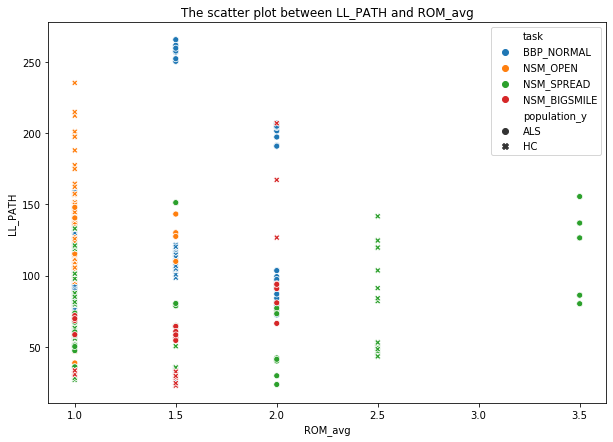

<Figure size 432x288 with 0 Axes>

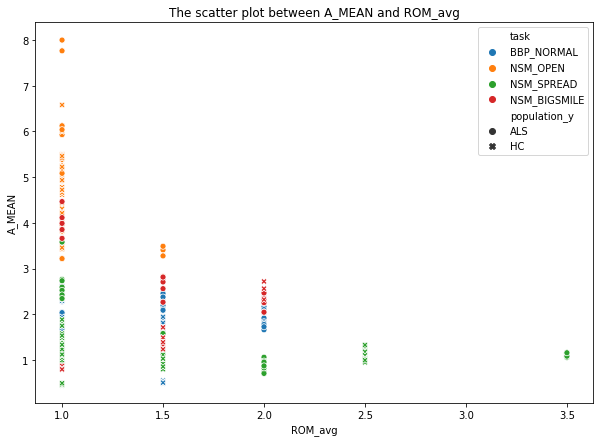

<Figure size 432x288 with 0 Axes>

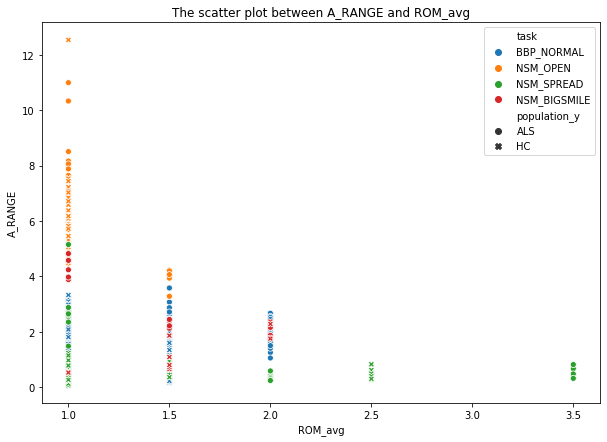

<Figure size 432x288 with 0 Axes>

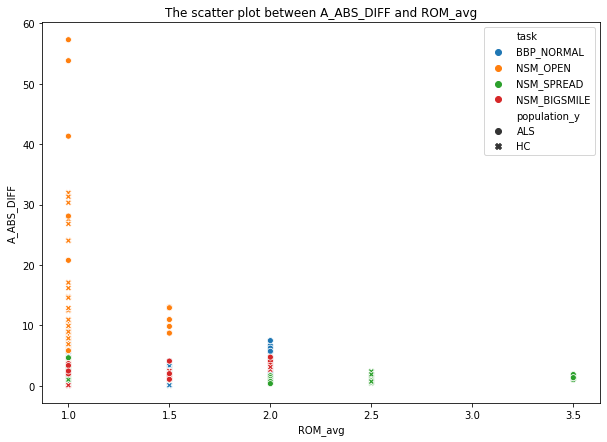

<Figure size 432x288 with 0 Axes>

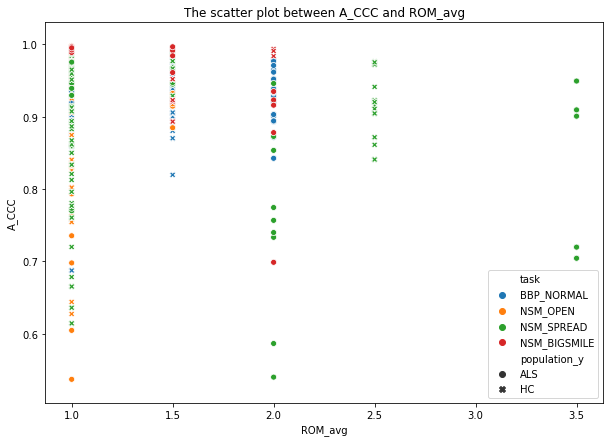

<Figure size 432x288 with 0 Axes>

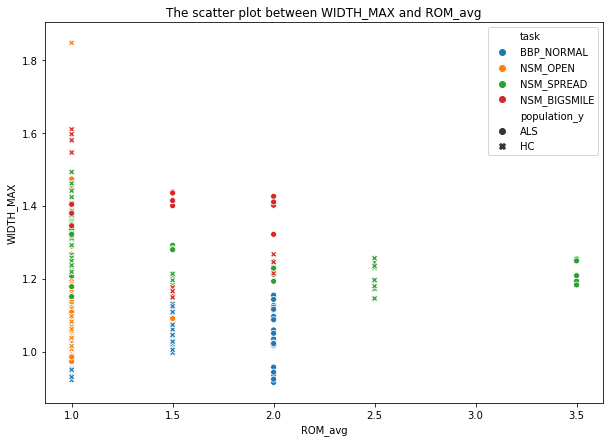

<Figure size 432x288 with 0 Axes>

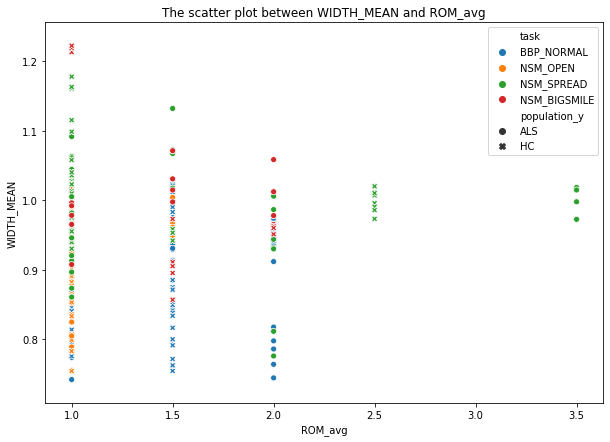

<Figure size 432x288 with 0 Axes>

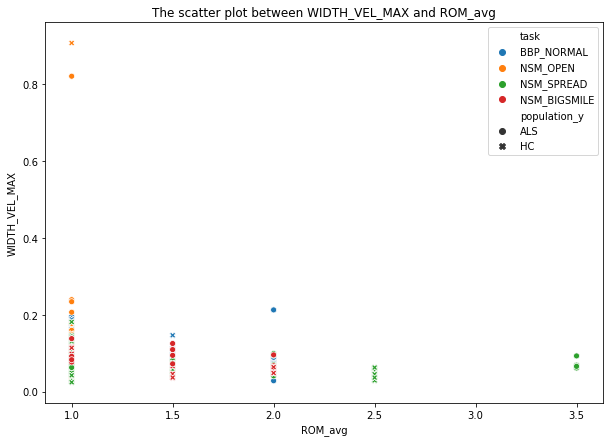

<Figure size 432x288 with 0 Axes>

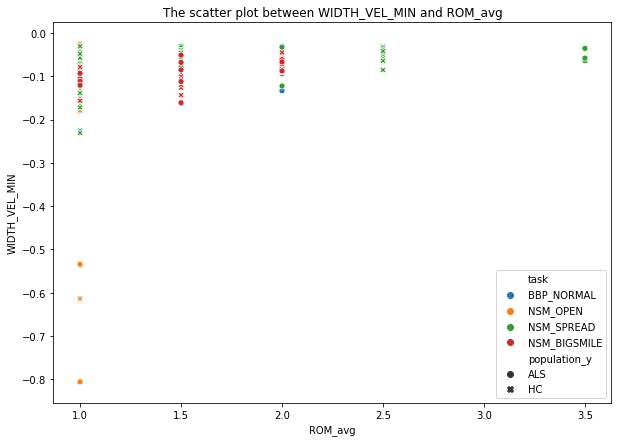

<Figure size 432x288 with 0 Axes>

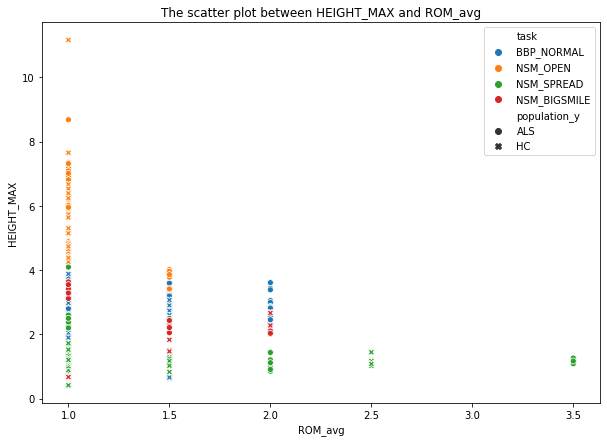

<Figure size 432x288 with 0 Axes>

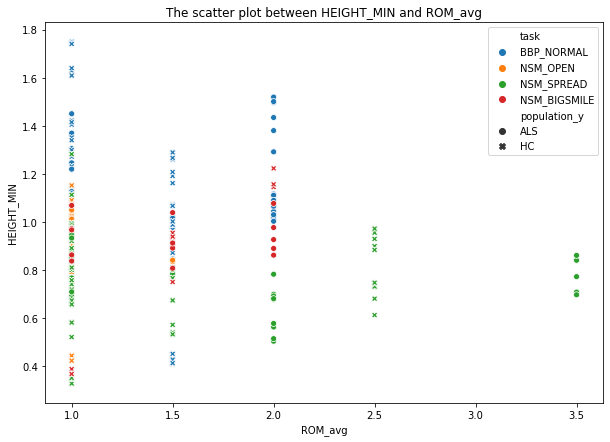

<Figure size 432x288 with 0 Axes>

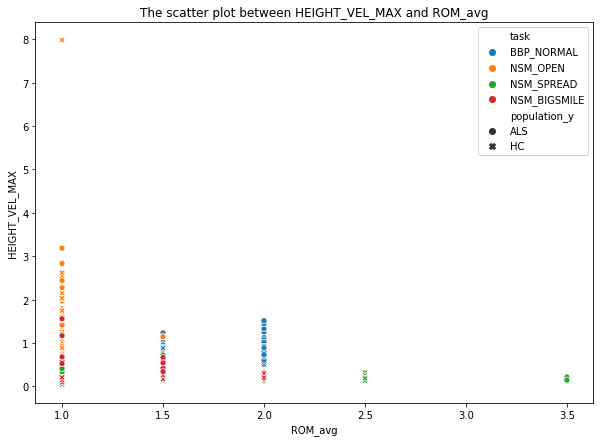

<Figure size 432x288 with 0 Axes>

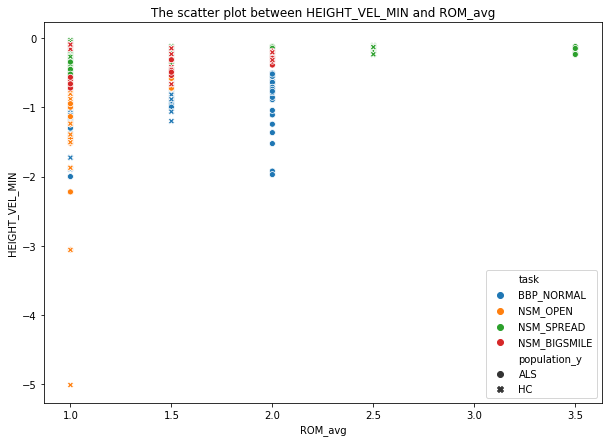

<Figure size 432x288 with 0 Axes>

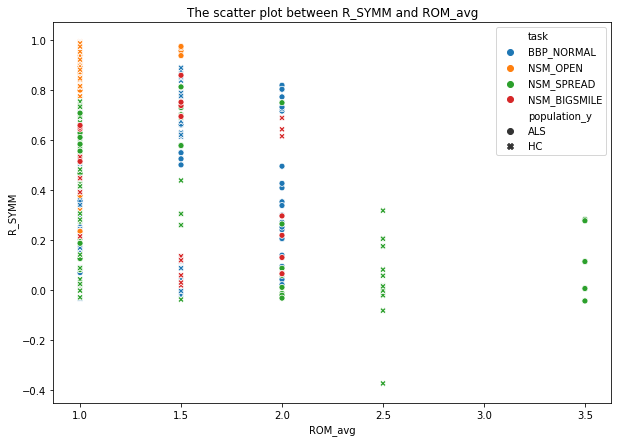

<Figure size 432x288 with 0 Axes>

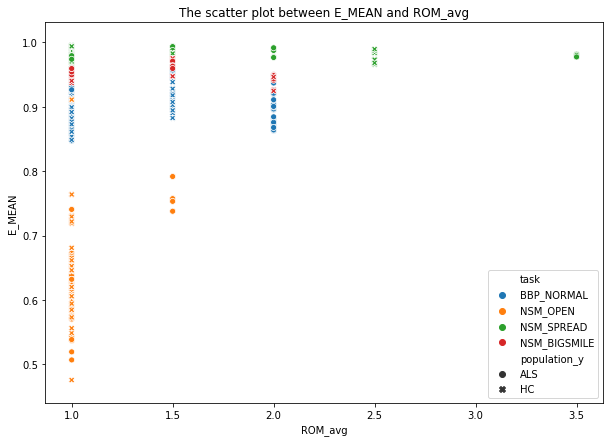

<Figure size 432x288 with 0 Axes>

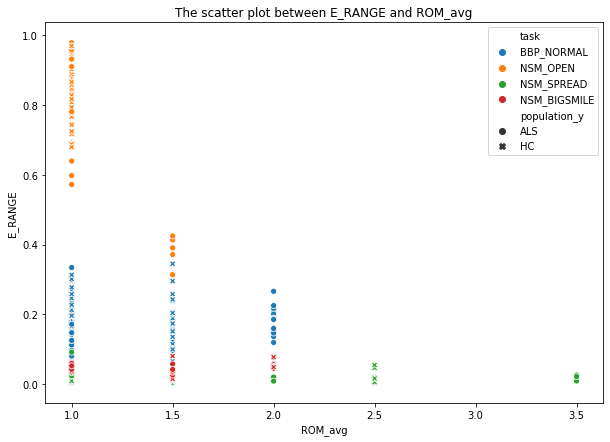

In [74]:
for f in als_features:
    plt.figure()
    ax, figure = plt.subplots(figsize=(10,7))
    score = 'ROM_avg'
    sns.scatterplot(x=score, y=f, data=new_als_and_scores, hue='task', style='population_y')
    plt.title('The scatter plot between {} and {}'.format(f, score ))

    # calculate spearman's correlation
    corr, _ = spearmanr(new_als_and_scores[f], new_als_and_scores[score])
    print('Spearmans correlation between {} and {}: %.3f'.format(f, score) % corr)

# UP to here

In [ ]:
ax, figure = plt.subplots(figsize=(10,7))
g = sns.countplot(x='task',data=als_df,hue='population')
g.set_xticklabels(g.get_xticklabels(), rotation=45)

# set axes labels and title
plt.ylabel('# of reps')
plt.title('Total Number of reps analyzed for each clinical task')
plt.show()

In [ ]:
#bbp_als_df_1.loc[~bbp_als_df_.subject_id.isin(a.subject_id)]



In [ ]:

np.intersect1d(diego_bbp.subject_id.unique(),neuroface_subjects)



Features of the tasks seperated into repetitions 

In [ ]:
# Standardized BBP 

path4 = r'/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/ALS_vs_Controls_database_finetuned/metric_output_BBP_NORMAL_standardized.csv'

bbp_df = pd.read_csv(path4)

print(len(bbp_df))
print(len(bbp_df.columns))
print(bbp_df.columns)
print(bbp_df.subject_id.unique())
bbp_df.head()


# Standardized Open

path6 = r'/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/ALS_vs_Controls_database_finetuned/metric_output_NSM_OPEN_standardized.csv'

open_df = pd.read_csv(path6)

print(len(open_df))
print(len(open_df.columns))
print(open_df.subject_id.unique())
print(open_df.columns)
open_df.head()

# Standardized Big Smile

path5 = r'/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/ALS_vs_Controls_database_finetuned/metric_output_NSM_BIGSMILE_standardized.csv'

bigs_df = pd.read_csv(path5)

print(len(bigs_df))
print(len(bigs_df.columns))
print(bigs_df.columns)
print(bigs_df.subject_id.unique())
bigs_df.head()


# Standardized Spread

path7 = r'/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/ALS_vs_Controls_database_finetuned/metric_output_NSM_SPREAD_standardized.csv'

spread_df = pd.read_csv(path7)

print(len(spread_df))
print(len(spread_df.columns))
print(spread_df.columns)
print(spread_df.subject_id.unique())
spread_df.head()

Plotting the corrolation of the 

In [ ]:
stroke_features = ['O_MAX', 'O_MIN','O_MAX_VEL', 'O_MIN_VEL', 'W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL',
       'A_MOUTH', 'R_LCRC', 'D_0', 'D_1', 'D_2', 'D_3']

for f in stroke_features:
    plt.figure()
    ax, figure = plt.subplots(figsize=(10,7))
    sns.scatterplot(x='Tot_avg', y=f, data=df_f2, hue='subject_id')

    # calculate spearman's correlation
    corr, _ = spearmanr(df_f2[f], df_f2['Tot_avg'])
    print('Spearmans correlation: %.3f' % corr)

## Stroke data

In [ ]:
# SLP SCORES

path = r'/Users/denizjafari/documents/CODE/ClinicalScore/NeuroFace_Dataset/Stroke/SLP_Assessment_PS.csv'
ps_df = pd.read_csv(path)

ps_df = ps_df.drop('Unnamed: 8', axis=1)

# average of the clinical scores 

ps_df['Tot_avg'] = ps_df.apply(lambda row: (row['Tot (SLP1)'] + row["Tot (SLP2)"])/2, axis=1)
ps_df['Symmetry_avg'] = ps_df.apply(lambda row: (row['Symmetry (SLP1)'] + row["Symmetry (SLP2)"])/2, axis=1)
ps_df['ROM_avg'] = ps_df.apply(lambda row: (row['ROM (SLP1)'] + row["ROM (SLP2)"])/2, axis=1)
ps_df['Speed_avg'] = ps_df.apply(lambda row: (row['Speed (SLP1)'] + row["Speed (SLP2)"])/2, axis=1)
ps_df['Variability_avg'] = ps_df.apply(lambda row: (row['Variability (SLP1)'] + row["Variability (SLP2)"])/2, axis=1)
ps_df['Fatigue_avg'] = ps_df.apply(lambda row: (row['Fatigue (SLP1)'] + row["Fatigue (SLP2)"])/2, axis=1)



print('len: ', len(ps_df))
print(ps_df.columns)
print(ps_df['Subject ID'].unique())
ps_df.head()

In [ ]:
tasks = ['BBP_NORMAL', 'PA', 'PATAKA', 'BLOW', 'KISS', 'OPEN', 'SPREAD', 'BIGSMILE', 'BROW']

def task_labeler(row):
    for t in tasks: 
        if t in row: 
            return t
    

ps_df['task'] = [task_labeler(x) for x in ps_df['File Name']]

ps_df.head()

In [ ]:
print(ps_df.shape)
print(ps_df['Subject ID'].unique())

In [ ]:
ps_df_bbp = ps_df[ps_df['task']== 'BBP_NORMAL']

In [ ]:
print(ps_df.shape)

print(ps_df_bbp.shape)
print(ps_df_bbp['Subject ID'].unique())
ps_df_bbp.head()

In [ ]:
path = r'/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/Stroke_vs_Controls_all_finetuned/metric_output_BBP_NORMAL_standardized.csv'

s_bbp_df = pd.read_csv(path)

print('len: ' , len(s_bbp_df))
print(len(s_bbp_df.columns))
print(s_bbp_df.columns)
print(s_bbp_df.subject_id.unique())
print(s_bbp_df.task.unique())
s_bbp_df.head()

In [ ]:
df_f = s_bbp_df.merge(ps_df_bbp, how= 'inner', left_on='subject_id', right_on='Subject ID')

print(df_f.size)
print(df_f.shape)
print(ps_df_bbp.shape)
print(s_bbp_df.shape)
print('len: ', len(df_f))

print(df_f.Tot_avg.isnull().count())

df_f.Tot_avg

In [ ]:
df_f.head()

In [ ]:
df_f.subject_id.unique()

In [ ]:
g = sns.FacetGrid(df_f, col="subject_id", col_wrap=3, height=5, ylim=(0, 20))
g.map(sns.pointplot, "O_MAX", "Tot_avg",color=".3", ci=None);

In [ ]:
ax, figure = plt.subplots(figsize=(10,7))
plt.scatter(df_f['Tot_avg'], df_f["O_MAX"])


# calculate spearman's correlation
corr, _ = spearmanr(df_f["O_MAX"], df_f['Tot_avg'])
print('Spearmans correlation: %.3f' % corr)

In [ ]:
ax, figure = plt.subplots(figsize=(10,7))
sns.scatterplot(x='Tot_avg', y="O_MAX", data=df_f, hue='subject_id')

# calculate spearman's correlation
corr, _ = spearmanr(df_f["O_MAX"], df_f['Tot_avg'])
print('Spearmans correlation: %.3f' % corr)

In [ ]:
path = r'/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/Stroke_vs_Controls_database_finetuned/metric_output_BBP_NORMAL_standardized.csv'

s_bbp2_df = pd.read_csv(path)

print(len(s_bbp2_df))
print(len(s_bbp2_df.columns))
print(s_bbp2_df.columns)
print(s_bbp2_df.subject_id.unique())
s_bbp2_df

In [ ]:
path = r'/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/ALS_vs_Controls_database_finetuned/metric_output_BBP_NORMAL_standardized.csv'

als_bbp2_df = pd.read_csv(path)

print(len(als_bbp2_df))
print(len(als_bbp2_df.columns))
print(als_bbp2_df.columns)
print(als_bbp2_df.subject_id.unique())
als_bbp2_df

### BBP_NORMAL ACROSS ALL SUBJECTS ANALYSIS

In [ ]:
# obtaining the clinical data for bbp task only 
df_bbp = slp_scores[slp_scores['task']== 'BBP_NORMAL']

# merging the clinical data with the features 
df_f1 = als_bbp2_df.merge(df_bbp, how= 'inner', left_on='subject_id', right_on='Subject ID')
df_f2 = s_bbp2_df.merge(df_bbp, how= 'inner', left_on='subject_id', right_on='Subject ID')

print(df_f1.subject_id.unique())
print(df_f2.subject_id.unique())


In [ ]:
df_f1.columns

In [ ]:
df_f2.columns

In [ ]:
stroke_features = ['O_MAX', 'O_MIN','O_MAX_VEL', 'O_MIN_VEL', 'W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL',
       'A_MOUTH', 'R_LCRC', 'D_0', 'D_1', 'D_2', 'D_3']

for f in stroke_features:
    plt.figure()
    ax, figure = plt.subplots(figsize=(10,7))
    sns.scatterplot(x='Tot_avg', y=f, data=df_f2, hue='subject_id')

    # calculate spearman's correlation
    corr, _ = spearmanr(df_f2[f], df_f2['Tot_avg'])
    print('Spearmans correlation: %.3f' % corr)

In [ ]:
stroke_to_regr_df = df_f2[['subject_id', 'task_x','Tot_avg', 'Symmetry_avg', 'ROM_avg', 'Speed_avg',
       'Variability_avg', 'Fatigue_avg', 'O_MAX', 'O_MIN','O_MAX_VEL', 'O_MIN_VEL', 'W_MAX', 'W_MIN', 'W_MAX_VEL', 'W_MIN_VEL',
       'A_MOUTH', 'R_LCRC', 'D_0', 'D_1', 'D_2', 'D_3']]



In [ ]:
stroke_to_regr_df

## Running RF Regression on the data

In [ ]:
def regressor(data, regr, col): 
    
    # col will tell us which clinical score we will predict, there are 5 of them 
    # regr is the type of regression model we use, start testing with rf regressor
    # data is the df 
    
    # we will do leave one subject out for evaluating the model 
    subjects  = data['subject_id'].unique()
    
    all_y = []
    all_y_star = []

    all_y_subject = []
    all_prob_subject = []
    
    for s in subjects: 
        values_train = data.loc[data.subject_id != s].values  
        
        ##### need to change this based on the df structure in my setup!!!!!!!!!
        ### change 4, for y is already made the change 
        X_train = values_train[:,8:]
        y_train = values_train[:,col]

        values_test = data.loc[data.subject_id == s].values  
        X_test = values_test[:,8:]
        # reps of the same task for a given subject 
        y_test = values_test[:,col]
        

        regr_fit = regr.fit(X_train,y_train)
        results = regr_fit.predict(X_test)#[:,1]
        
        all_y.append(y_test)
        all_y_star.append(results)
        
        
           # average out the predictions of the reps of the task to get one final vlue for clinical score
        all_y_subject.append(np.mean(y_test[:]))
        all_prob_subject.append(np.mean(results[:]))
        
        #print(clf_fit.feature_importances_)
        #print('y-all-subj: ' , all_y_subject)
        #print('y_all_star-subj: ', all_prob_subject)
        

    
    #flat_list_y = [item for sublist in all_y for item in sublist]
    #flat_list_prob = [item for sublist in all_y_star for item in sublist]
    
    #print('y-all-flat: ' , flat_list_y)
    #print('y_all_star-flat: ', flat_list_prob)
    #return np.array(all_y_subject).astype(int),np.array(all_prob_subject), np.array(flat_list_y).astype(int), np.array(flat_list_prob)
    return np.array(all_y_subject), np.array(all_prob_subject)

In [ ]:
### BBP_NORMAL Task 

regr = RandomForestRegressor(n_jobs=-1, random_state=42)

tasks = ['BBP_NORMAL', 'NSM_OPEN', 'NSM_SPREAD', 'NSM_BIGSMILE']
task = 0 # 0-> NORMAL_BBP, 1-> NSM_OPEN, 2-> NSM_SPREAD, 3->NSM_BIGSMILE




#file = r".\results\test_multi_finetuned\metric_output_"+tasks[task]+".csv"
#Data_3D = pd.read_csv(file, index_col=0)

clinical_measure = ['Tot_avg', 'Symmetry_avg', 'ROM_avg', 'Speed_avg','Variability_avg', 'Fatigue_avg']
col = 3  # 2-> Tot_avg, 3-> Symmetry_avg, 4-> ROM_avg, 5-> Speed_avg, 6-> Variability_avg, 7-> Fatigue_avg
#all_y_subject_finetuned,all_prob_subject_finetuned,all_y_finetuned,all_prob_finetuned = regressor(Data_3D, regr)

all_y_subject_finetuned,all_prob_subject_finetuned = regressor(stroke_to_regr_df, regr, col)

idx = col-3
print('clinical_measure: ', clinical_measure[idx])
print("y: ",all_y_subject_finetuned)
print("prediction: ",all_prob_subject_finetuned)
print()

if 0:

    fpr_finetuned, tpr_finetuned, thresholds_finetuned = roc_curve(all_y_subject_finetuned,all_prob_subject_finetuned,pos_label=0)
    roc_auc_finetuned= auc(fpr_finetuned, tpr_finetuned)



    plt.figure(1, figsize=(12,6))
    plt.plot(fpr_finetuned, tpr_finetuned, lw=2, alpha=0.75, color='r');

    plt.plot(np.linspace(0,1,100), np.linspace(0,1,100),'k')
    plt.ylabel('True Positive');
    plt.xlabel('False Positive');
    plt.legend(['finetuned model - AUC ='+str(np.round(roc_auc_finetuned,2))]);

In [ ]:
tasks = ['BBP_NORMAL', 'NSM_OPEN', 'NSM_SPREAD', 'NSM_BIGSMILE']
task = 0 # 0-> NORMAL_BBP, 1-> NSM_OPEN, 2-> NSM_SPREAD, 3->NSM_BIGSMILE


file = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/results/Stroke_vs_Controls_new_finetuned/metric_output_"+tasks[task]+".csv"
Data_3D = pd.read_csv(file, index_col=0)
Data_3D

In [ ]:
subjects_to_remove = 'NF11|OP01'




In [ ]:
Data_3D.subject_id.unique()

In [ ]:
Data_3D[Data_3D['subject_id'].str.contains(subjects_to_remove,regex=True)==False] 

In [ ]:
    
if 0:    
    path3 = r'/Users/denizjafari/documents/CODE/ClinicalScore/for_deniz.csv'

    df3 = pd.read_csv(path3)

    print(len(df3))
    print(df3.columns)
    df3.head()
    
    
# average of the clinical scores 

#df['Tot_avg'] = df.apply(lambda row: (row['Tot (SLP1)'] + row["Tot (SLP2)"])/2, axis=1)
#df['Symmetry_avg'] = df.apply(lambda row: (row['Symmetry (SLP1)'] + row["Symmetry (SLP2)"])/2, axis=1)
#df['ROM_avg'] = df.apply(lambda row: (row['ROM (SLP1)'] + row["ROM (SLP2)"])/2, axis=1)
#df['Speed_avg'] = df.apply(lambda row: (row['Speed (SLP1)'] + row["Speed (SLP2)"])/2, axis=1)
#df['Variability_avg'] = df.apply(lambda row: (row['Variability (SLP1)'] + row["Variability (SLP2)"])/2, axis=1)
#df['Fatigue_avg'] = df.apply(lambda row: (row['Fatigue (SLP1)'] + row["Fatigue (SLP2)"])/2, axis=1)

# the ranges 


def clinical_severity(row):
    if row['Tot_avg'] ==5 :
        return 'Normal'
    if row['Tot_avg'] > 5 and row['Tot_avg'] <=10 :
        return 'Mild'
    if row['Tot_avg'] <=15 and row['Tot_avg'] > 10:
        return 'Moderate'
    if row['Tot_avg'] >15 :
        return 'Severe'
    return 'Wrong_Value'

#df['Clinical_Cat'] = df.apply (lambda row: clinical_severity(row), axis=1)

# lets see the severity of the oro-facial defecits in the clinical population 

if 0:
    sns.countplot(x='Clinical_Cat',data=df)
    # set axes labels and title
    plt.ylabel('Number of People')
    plt.title('Total Number of People in each Clinical category')
    plt.show()
    
if 0:
    plt.scatter(df['Tot (SLP1)'], df['Tot (SLP2)'])
    # calculate spearman's correlation
    corr, _ = spearmanr(df['Tot (SLP1)'], df['Tot (SLP2)'])
    print('Spearmans correlation: %.3f' % corr)
    
    
if 0:
    sns.boxplot(x=df['Subject ID'], y=df['Tot (SLP1)'])
    plt.title('Distribution of SLP1 Total Score')
    plt.show()

    sns.boxplot(x=df['Subject ID'], y=df['Tot (SLP2)'])
    plt.title('Distribution of SLP2 Total Score')
    plt.show()

    sns.boxplot(x=df['Subject ID'], y=df['Tot_avg'])
    plt.title('Distribution of SLP Avg Total Score')
    plt.show()